In [39]:
import numpy as np
import pandas as pd
import h5py
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from statistics import mean
import scipy
from pathlib import Path
import math
from scipy.optimize import curve_fit,least_squares,leastsq
from scipy.interpolate import interp1d
from scipy.optimize import Bounds
from scipy.fft import fft, fftfreq
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal 
from scipy.signal import lombscargle
import operator
import matplotlib.ticker as ticker

In [40]:
#Plotting Options
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.style.use('seaborn')

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["font.family"] = "Arial"

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

#make colormap indicating cloud phase
liquid = cm.get_cmap('Reds_r', 60)
mixed = cm.get_cmap('RdPu_r', 90)
ice = cm.get_cmap('PuBu_r', 120)

newcolors = np.vstack((ice(np.linspace(0, .5, 60)),
                       mixed(np.linspace(0, .5, 90)),
                       liquid(np.linspace(0, .5, 120))))
newcmp = ListedColormap(newcolors, name='Phases')

In [41]:
path = '/Volumes/KESU/image_data/'

#choose filepath to desired data
calibration_path = '/Volumes/KESU/may19/'

def get_dataset_keys(f):
    keys = []
    f.visit(lambda key : keys.append(key) if isinstance(f[key], h5py.Dataset) else None)
    return keys

a_file = h5py.File(path+ 'poldata.h5', "r")
print(a_file.keys())
a_file.close()

<KeysViewHDF5 ['angles', 'nedt', 'responses1', 'responses2', 'responses_err1', 'responses_err2', 'var', 'var1', 'var2', 'waves']>


In [42]:
df_ircsp = pd.read_csv("/Users/kirahart/Dropbox/Research/balloon/telemetry_data/IRCSP_TELEMETRY.csv")
df_ircsp

Unnamed: 0        time  acceleration  t_sbc  t_ircsp  humidity  \
0              0  1627078722      0.975586      1    22.31     20.99   
1              1  1627078735      0.967285      1    22.33     20.93   
2              2  1627078748      0.969727      1    22.31     20.90   
3              3  1627078763      0.973633      1    22.29     20.85   
4              4  1627078781      0.970703      1    22.27     20.82   
...          ...         ...           ...    ...      ...       ...   
2086        2086  1627092532      0.960938      1    39.22     11.11   
2087        2087  1627092544      0.951172      1    39.25     11.08   
2088        2088  1627092556      0.961914      1    39.26     11.06   
2089        2089  1627092568      0.958008      1    39.28     11.03   
2090        2090  1627092579      0.955566      1    39.30     11.01   

      pressure  voltage  cam1_t  cam2_t             datetime  
0       876.19  4.65298    26.9    26.8  2021-08-30 10:49:07  
1       876.16  4.68231    26.9    26.8  2021-08-30 10:50:07  
2       876.16  4.70186    26.9    26.8  2021-08-30 10:50:07  
3       876.18  4.71163    26.9    26.8  2021-08-30 10:50:06  
4       876.22  4.70674    30.3    30.2  2021-08-30 10:50:06  
...        ...      ...     ...     ...                  ...  
2086      8.67  5.00000    55.8    56.9  2021-08-30 19:20:11  
2087      8.63  5.00000    55.8    56.9  2021-08-30 19:20:11  
2088      8.63  5.00000    55.9    56.9  2021-08-30 19:20:12  
2089      8.66  5.00000    55.9    56.9  2021-08-30 19:20:12  
2090      8.64  5.00000    55.9    57.0  2021-08-30 19:20:12  

[2091 rows x 11 columns]

# Import Calibration Data

Import hdf5 data generated from calculate_POL 

In [44]:
with h5py.File(path+ 'poldata.h5', "r") as file:
    waves = file['/waves'][()]
    measurement = file['/angles'][()]
    
    R1 = file['/responses1'][()]
    R2 = file['/responses2'][()]
    
    E1 = file['responses_err1'][()]
    E2 = file['responses_err2'][()]

## Import Spectral Calibration Data

In [43]:
a_file = h5py.File(calibration_path+ 'calibration.h5', "r")
print(a_file.keys())
a_file.close()

<KeysViewHDF5 ['pixel', 'polarization', 'radiometric', 'transmission']>


In [45]:
with h5py.File(calibration_path+ 'calibration.h5', "r") as file:
    lambda_c = file['/pixel/wavelength'][()]
    pixel1 = file['/pixel/pixel1'][()]
    pixel2 = file['/pixel/pixel2'][()]

## Import AOLP dependent transmission

This function will correct for differences in transmission over a single period

In [46]:
with h5py.File(calibration_path+ 'calibration.h5', "r") as file:
    t_unpol = file['/transmission/t_unpol'][()]
    t_pol = file['/transmission/t_pol'][()]

In [47]:
def transmission_correction(I1,I2,iterations):
    T = 1
    i = 0
    while i < iterations:
        t = np.mean(I1)/np.mean(I2)
        T_update = T*t
        I2_update = t*I2
        I2 = I2_update
        T= T_update
        i = i+1;
    return(T)

In [48]:
def MOD(a,band):
#calculate modulation function for calibration data
    i = band

    start = pixel1[i]
    stop  = pixel2[i]
    i1 = R1[a,start:stop]
    i2 = R2[a,start:stop]
    
    e1 = E1[a,start:stop]
    e2 = E2[a,start:stop]
    
    transmission_aolp = transmission_correction(i1,i2,5)

    I1 = i1/t_unpol[start:stop]
    I2 = i2*transmission_aolp
    
    I1e = e1/t_unpol[start:stop]
    I2e = e2*transmission_aolp

    mod_a = (I1-I2)/(I1+I2)
    mod_e = (e1/100)
                            
    return([mod_a,mod_e])

# Demodulation in Fourier Space

## periodogram

In [49]:
from astropy.timeseries import LombScargle
wavenums = np.divide(1,np.multiply(lambda_c,1e-4))

0.02966923076923078
-0.12381317343891902 -0.32575604595960017


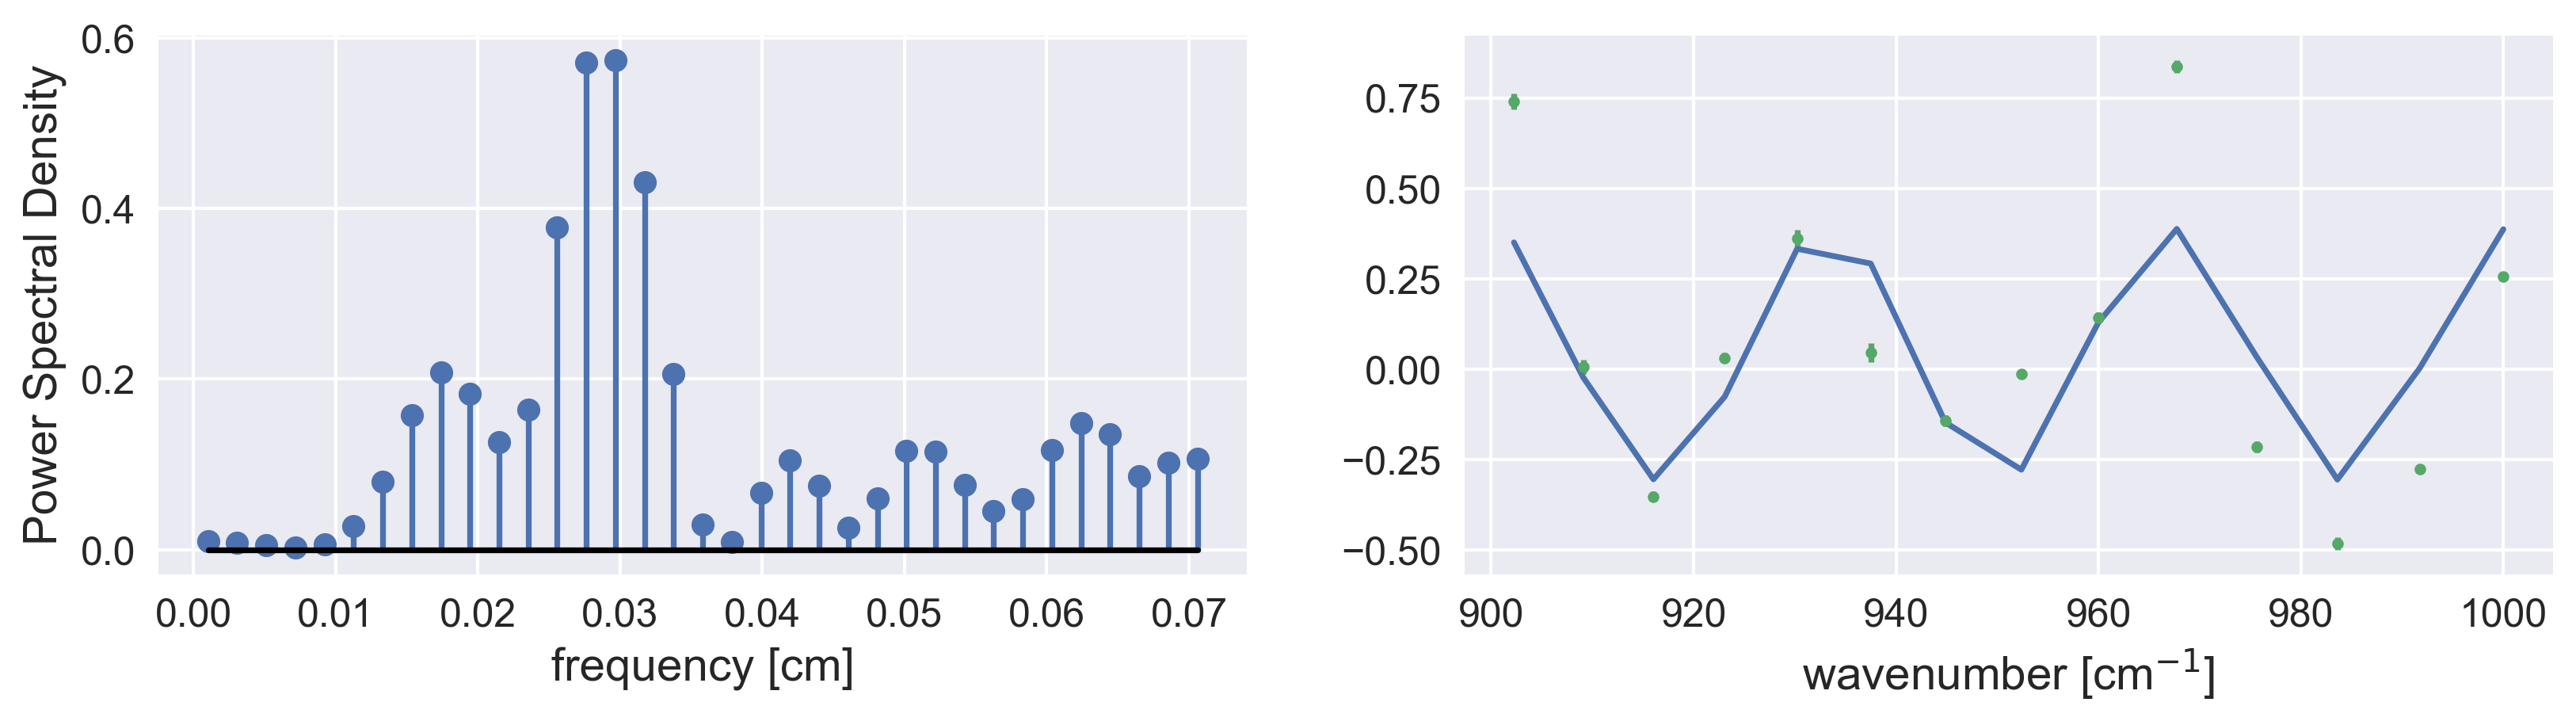

In [51]:
a = 100
j = 35
start = pixel1[j]
stop  = pixel2[j]
n = stop-start;

x = wavenums[start:stop]
[y,dy] = MOD(a,j)

ls = LombScargle(x, y,dy)
frequency, power = ls.autopower(nyquist_factor= 1) #sampling in 1 period intervalsLombScargle(x, y,dy)

best_frequency = frequency[np.argmax(power)]
t_fit = x
y_fit = ls.model(t_fit, best_frequency)

print(best_frequency)
[offset,u,q] = ls.model_parameters( best_frequency)
print(q,u)

fig, axes = plt.subplots(1,2,figsize=(13, 3))
plt.gcf().set_dpi(300)
axes[0].stem(frequency, power,basefmt = 'k')
axes[0].set_xlabel('frequency [cm]')
axes[0].set_ylabel('Power Spectral Density')     

axes[1].plot(t_fit,y_fit)
axes[1].set_xlabel('wavenumber [cm$^{-1}$]')
axes[1].errorbar(x,y,yerr = dy,fmt='.')
plt.show()

In [52]:
with h5py.File(calibration_path+ 'calibration.h5', "r") as file:
    carrier = file['/polarization/carrier'][()]
    WQ = file['/polarization/WQ'][()]
    WU = file['/polarization/WU'][()]

In [53]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return idx

def LombModel(a,j,thresh,dolp_lim):
    start = pixel1[j]
    stop  = pixel2[j]
    n = stop-start;
    freq = carrier[j]
    Wq= WQ[j]
    Wu= WU[j]

    x = wavenums[start:stop]
    [y,dy] = MOD(a,j)

    ls = LombScargle(x, y,dy)
    frequency, power = ls.autopower(nyquist_factor= 1) #sampling in 1 period intervalsLombScargle(x, y,dy)
    
    error = np.mean(np.abs(y- ls.model(x, freq))/np.abs(y))

    idx = find_nearest(frequency, freq)
    prob = ls.false_alarm_probability(power[idx])  
    if prob < thresh:
        [offset,u,q] = ls.model_parameters(freq)
        u = u*Wu
        q = q*Wq
        dolp = ((u)**2+(q)**2)**0.5 
        if dolp > dolp_lim or dolp < 0:
            [prob,u,q,dolp] =[np.NAN,np.NAN,np.NAN,np.NAN]
        if error/dolp > 100:
            [prob,u,q,dolp] =[np.NAN,np.NAN,np.NAN,np.NAN]
    else:
        [prob,u,q,dolp] =[np.NAN,np.NAN,np.NAN,np.NAN]
    
    return([dolp,0.5*np.arctan2(u,q),q,u,error])

# Radiometric Calculation

In [54]:
from radiometric.LUT import create_LUT_df, determine_reference, applyNUC_to_LUT

from NUC.NUC_functions import import_NUC, apply_NUC, get_slice, determine_slope
from NUC.NUC_functions import determine_dark, apply_DFC_to_df
from NUC.NUC_functions import pixel_registration

from matplotlib import cm
from scipy.optimize import curve_fit
import matplotlib.colors as colors


In [55]:
""" Fitting Function"""
def func(x, a, b):
    y = (x/a)**0.25 +b
    return y

In [56]:
with h5py.File(calibration_path+ 'calibration.h5', "r") as file:
    nedt = file['/radiometric/nedt'][()]
    var = file['/radiometric/var'][()]

In [57]:
def get_BT(j,i,f):
    bt = []
    Et = []
    for a in range(i,f):
        start = pixel1[j]
        stop  = pixel2[j]

        response = np.sum(R1[a,start:stop]+R2[a,start:stop])
        response_err = np.sum(E1[a,start:stop]+E2[a,start:stop])
        bt.append(func(response,var[j,0],var[j,1]))
        Et.append(func(response+response_err/2,var[j,0],var[j,1])-func(response-response_err/2,var[j,0],var[j,1]))
    return([bt,Et])


In [58]:
2600-2091

509

/Users/kirahart/opt/anaconda3/envs/database/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


ValueError: 'x' and 'y' must have the same size

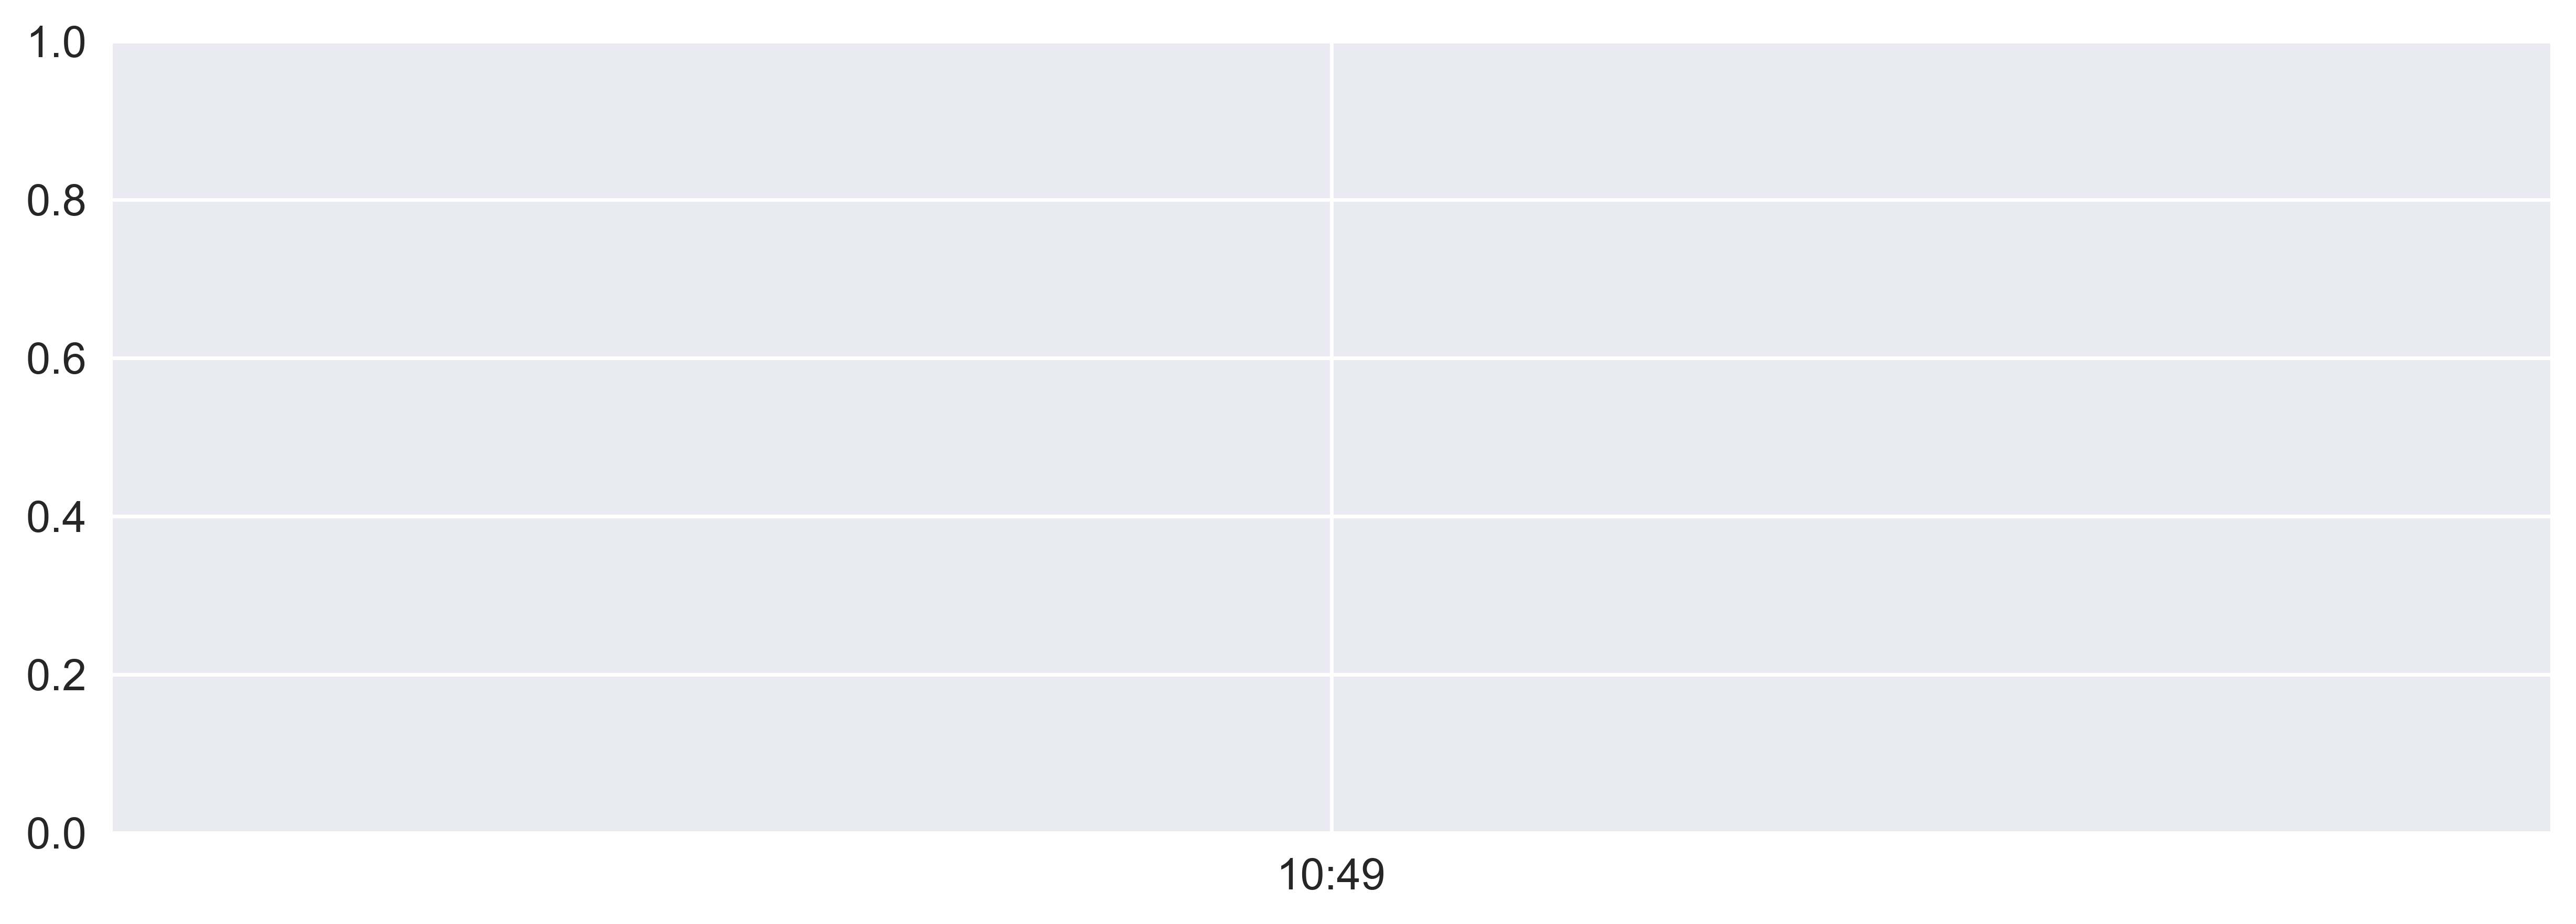

In [59]:
times = []
alt = []
a = .4
ii = 0
ff = 2600
for i in range(len(df_ircsp)):
    tt = df_ircsp['datetime'].loc[i]
    alt.append(df_ircsp['pressure'].loc[i])
    times.append(tt[11:16])
    
[bt1,et1] = get_BT(17,ii,ff)
[bt2,et2] = get_BT(26,ii,ff)
[bt3,et3] = get_BT(35,ii,ff)

fig1, ax = plt.subplots(1,1,figsize = (12,4),dpi = 500)
plt.errorbar(times[:2299],bt1,yerr = np.divide(et1,1),fmt = '.-b',label = "8.8",alpha = a)
plt.errorbar(times[:2299],bt2,yerr = np.divide(et2,1),fmt = '.-g',label = "9.5",alpha = a)
plt.errorbar(times[:2299],bt3,yerr = np.divide(et2,1),fmt = '.-r',label = "11.0",alpha = a)
plt.legend(fontsize = 14,title = 'Band [$\mathdefault{\mu}$m]')
plt.ylabel("Brightness Temperature [K]")
plt.xlabel('Time (UTC)')
ax.xaxis.set_major_locator(ticker.MultipleLocator(50))

ax.axvline(20,color='gray', linewidth=1)#,label = "Launch")
ax.axvline(100,color='gray', linewidth=1)#,label = "Launch")

ax.text(21, 245, 'Altitude = 5 km',color = 'k')
ax.text(101, 245, 'Altitude = 30 km',color = 'k')

plt.axhspan(220, 233, color='b', alpha=0.2, lw=0)
plt.axhspan(233, 273, color='purple', alpha=0.2, lw=0)
plt.axhspan(273, 295, color='red', alpha=0.2, lw=0)

plt.ylim(240,292)
plt.show()

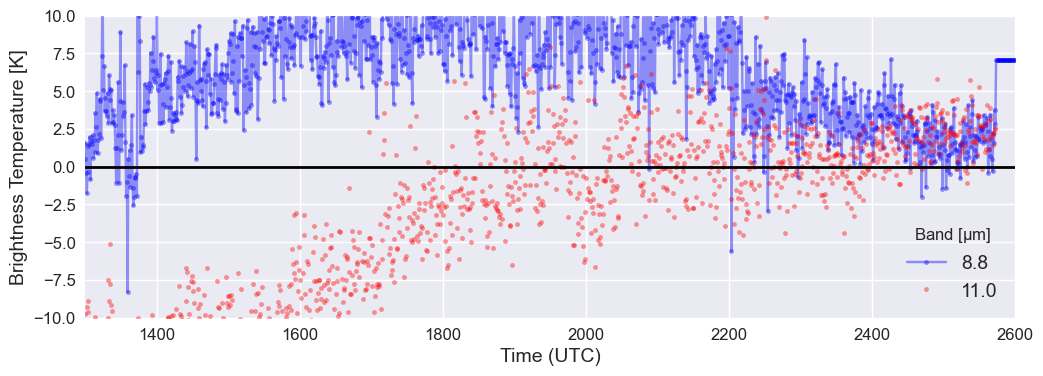

In [60]:
 al = 44330 * (1 - np.divide(alt,1013.25)**(1/5.255) )/1000 

fig1, ax = plt.subplots(1,1,figsize = (12,4),dpi = 100)
plt.plot(np.subtract(bt1,bt2), '.-b',label = "8.8",alpha = a)

plt.plot(np.subtract(bt3,bt2),'.r',label = "11.0",alpha = a)
plt.legend(fontsize = 14,title = 'Band [$\mathdefault{\mu}$m]')
plt.ylabel("Brightness Temperature [K]")
plt.xlabel('Time (UTC)')

ax.axhline(0,color='k', linewidth=2)#,label = "Launch")
plt.xlim(1300,2600)
plt.ylim(-10,10)


plt.show()


In [61]:
start = 1300
stop = 1400
print(30/650 *(start-1300) )
print(30/650 *(stop-1300) )

print(np.mean(np.subtract(bt3,bt1)[start:stop]))
print(np.std(np.subtract(bt3,bt1)[start:stop]))
print(np.mean(np.subtract(bt3,bt2)[start:stop]))
print(np.std(np.subtract(bt3,bt2)[start:stop]))

0.0
4.615384615384616
-17.102915662735395
4.179874758373438
-14.091086173571904
3.5955267073181094


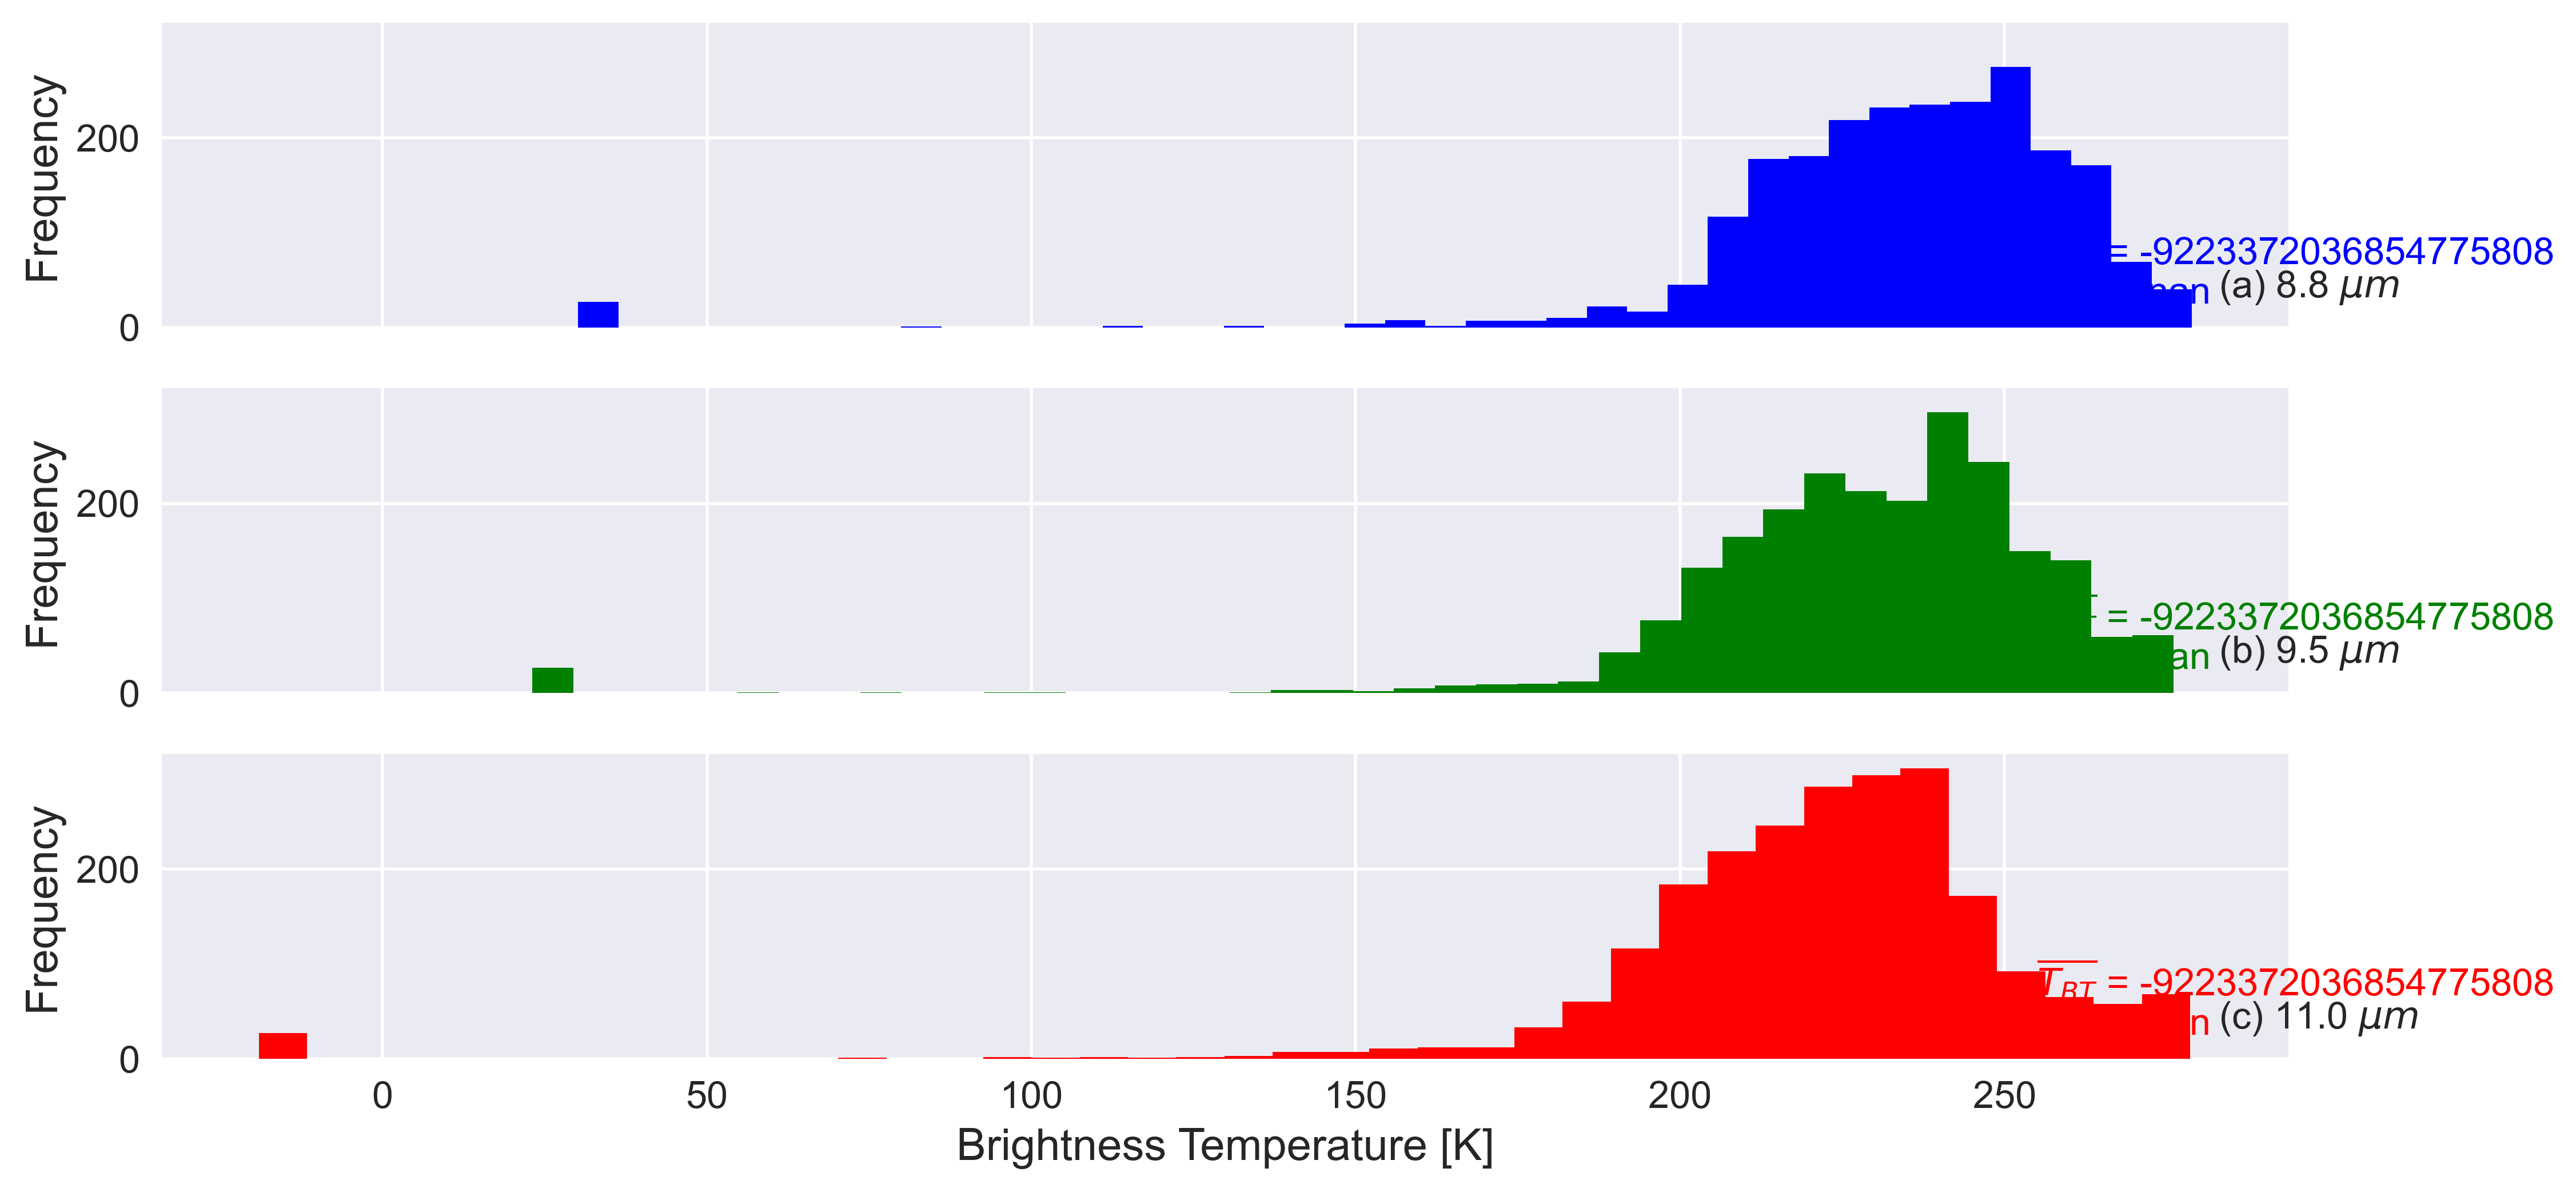

In [62]:
ran = .2
fig,ax = plt.subplots(3,1,figsize = (12,6),dpi = 200,sharex = True, sharey = True)
plt.gcf().set_dpi(400)
ax[0].hist(bt1[300:] ,40, color = 'blue')
ax[1].hist(bt2[300:] , 40,color = 'green')
ax[2].hist(bt3[300:] , 40,color = 'red')

bts = [bt1,bt2,bt3]
colors = ["b","g","r"]
labels = ["(a) 8.8 $\mu m$","(b) 9.5 $\mu m$","(c) 11.0 $\mu m$"]
ax[2].set_xlabel("Brightness Temperature [K]")
for i in range(3):
    ax[i].set_ylabel("Frequency")
    ax[i].text(255,25,"$\overline{T_{BT}}$ = "+str(np.int64(np.mean(bts[i][300:])))+"\n$\sigma_{T_{BT}}$ = "+str(np.round(np.std(bts[i][300:]),1)),color = colors[i])
    ax[i].text(283,32,labels[i])
plt.show()

Text(0, 0.5, 'Estimated Error [K]')

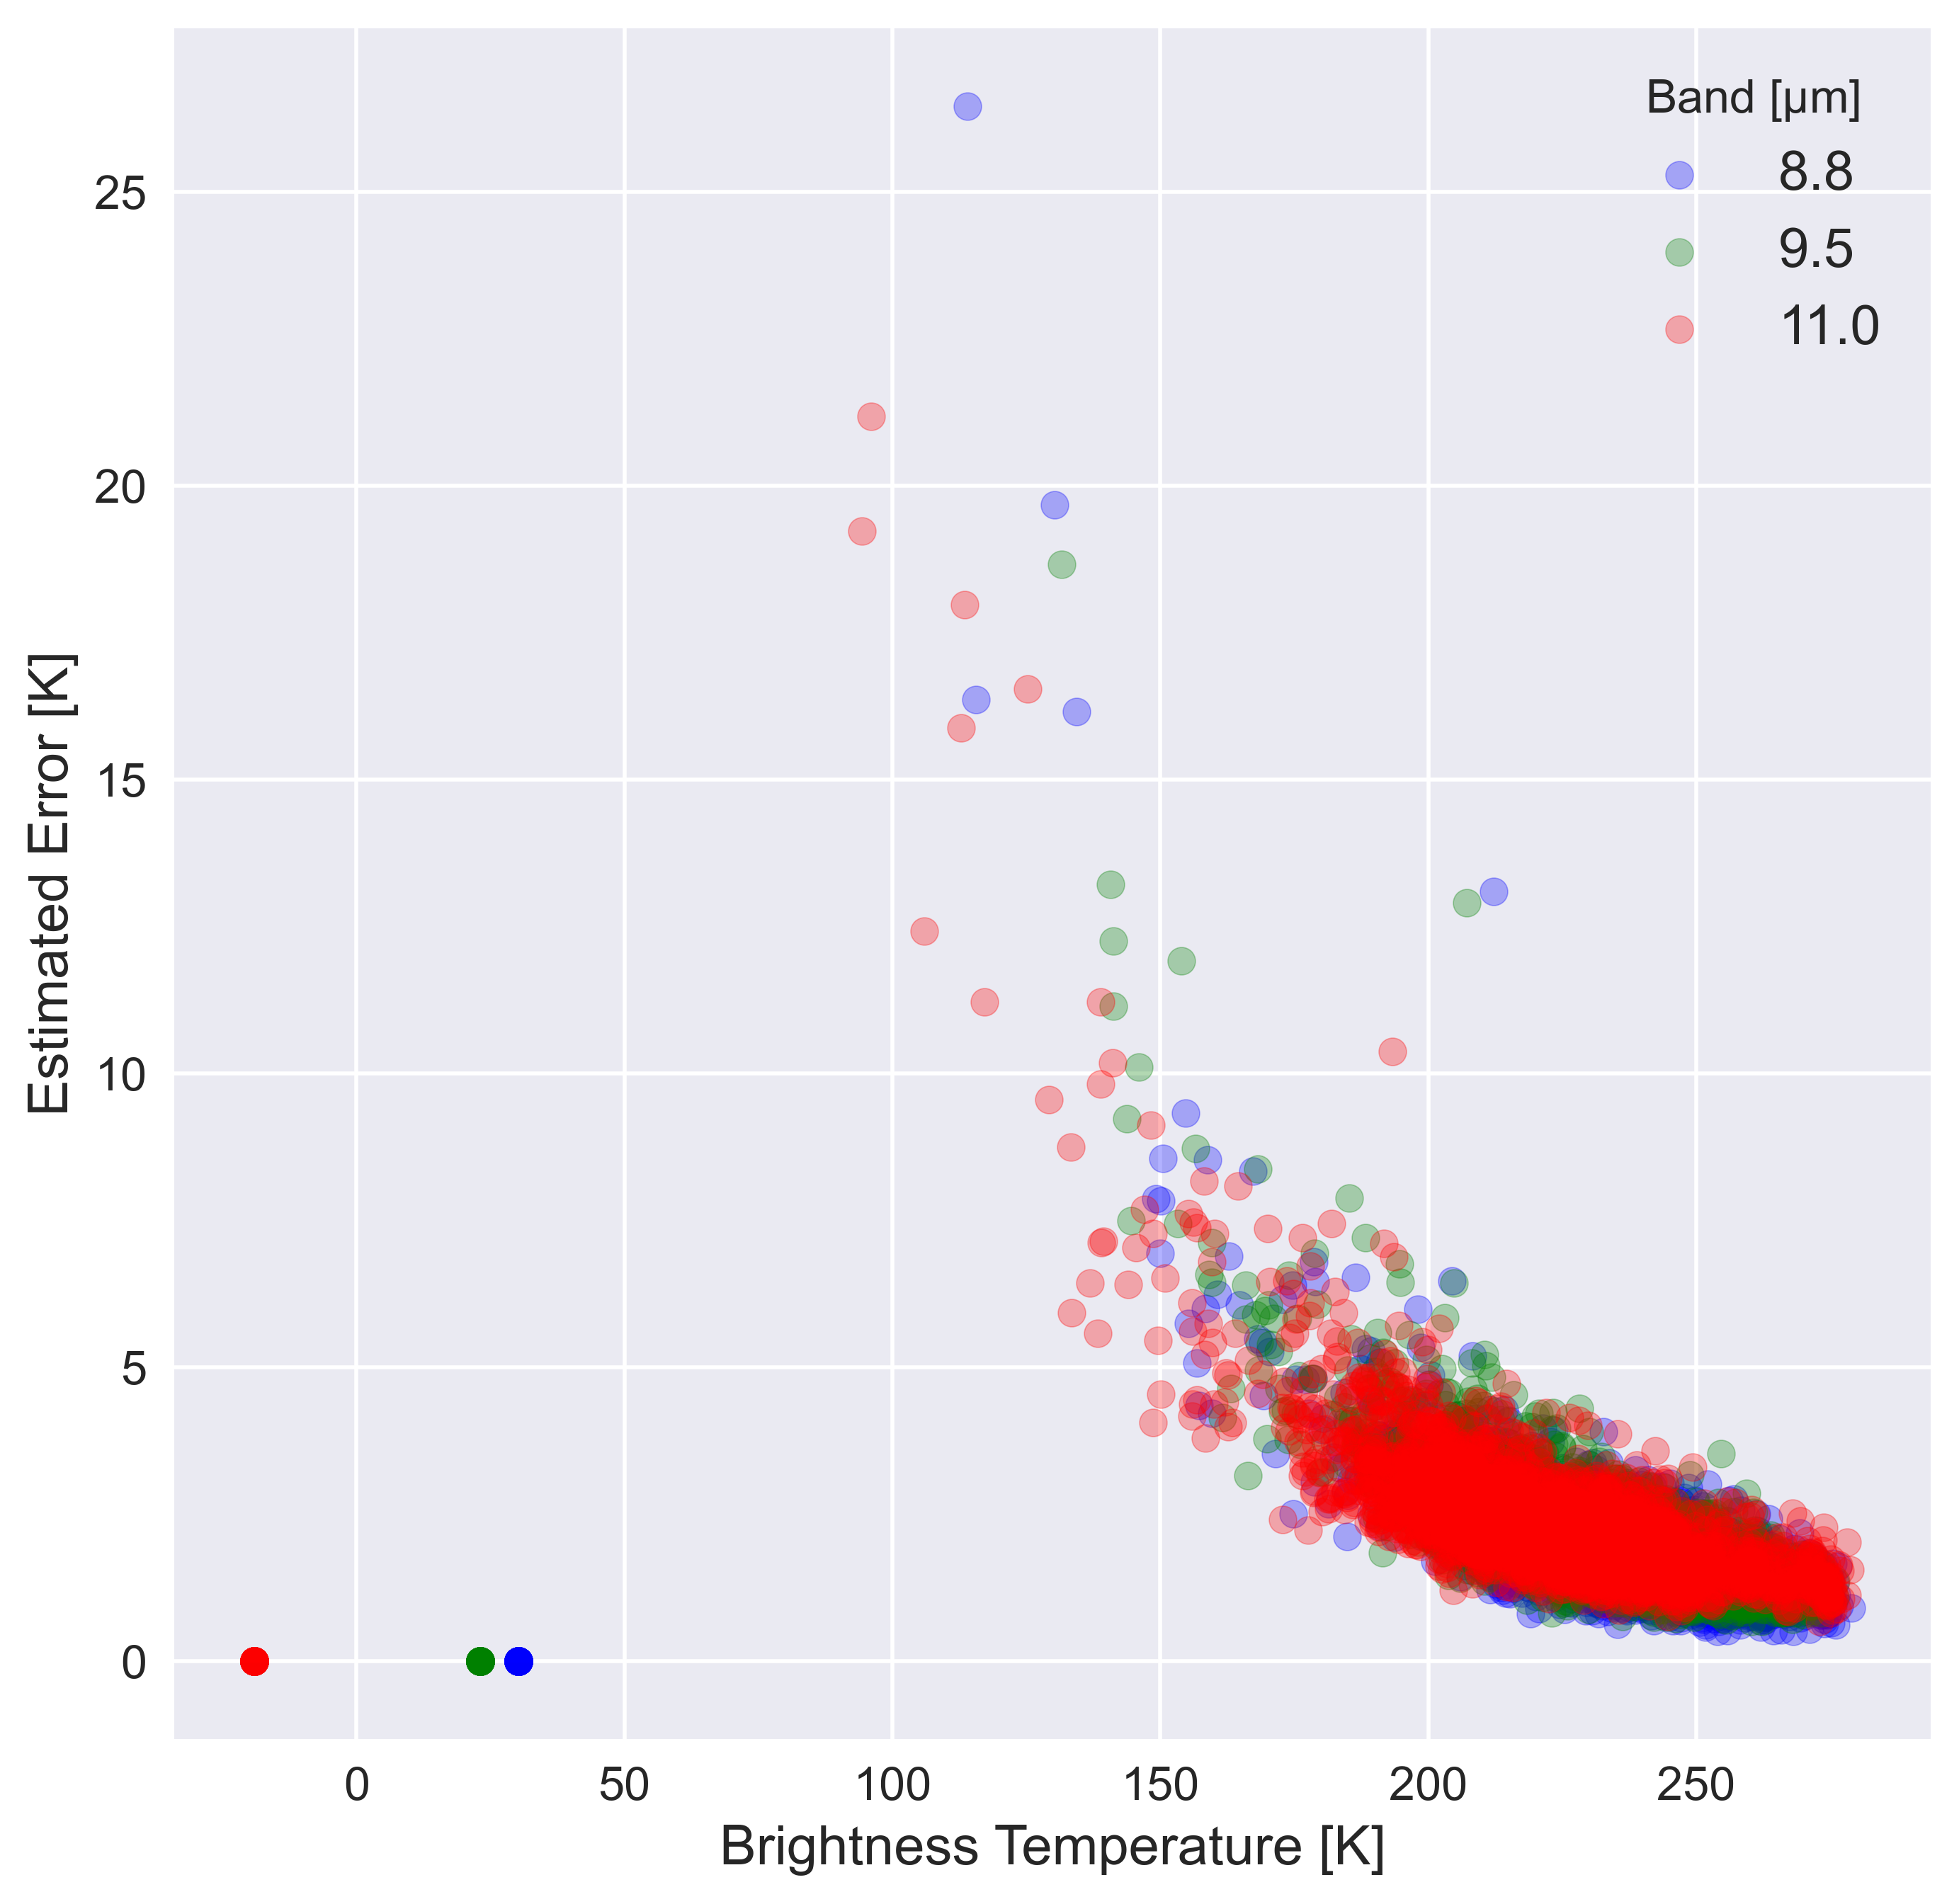

In [63]:
ran = .2
fig,ax = plt.subplots(1,1,figsize = (8,8),dpi = 300,sharex = True, sharey = True)
plt.gcf().set_dpi(400)
ax.scatter(bt1,et1,color = 'blue',label = "8.8",alpha = .3)
ax.scatter(bt2,et2,color = 'green',label = "9.5",alpha = .3)
ax.scatter(bt3,et3,color = 'red',label = "11.0",alpha = .3)

plt.legend(fontsize = 14,title = 'Band [$\mathdefault{\mu}$m]')
plt.xlabel("Brightness Temperature [K]")
plt.ylabel("Estimated Error [K]")


In [64]:
bts = []
ets = []
for i in range(0,36):
    [bt1,et1] = get_BT(i,ii,ff)
    bts.append(bt1)
    ets.append(et1)

/Users/kirahart/opt/anaconda3/envs/database/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


In [65]:
#Polarimetric Retrievals
ff = 2300
ii = 1400
windows=range(0,34,1)
results = np.zeros([34,ff-ii,5])
for i in range(34):
    j = windows[i]
    for a in range(ii,ff,1):
        results[i,a-ii] = LombModel(a,j,1,.2)  

/Users/kirahart/opt/anaconda3/envs/database/lib/python3.7/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/main.py:216: RuntimeWarning: divide by zero encountered in power
  PLS = METHODS[method](*args, **kwds)
/Users/kirahart/opt/anaconda3/envs/database/lib/python3.7/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/main.py:216: RuntimeWarning: invalid value encountered in double_scalars
  PLS = METHODS[method](*args, **kwds)
/Users/kirahart/opt/anaconda3/envs/database/lib/python3.7/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/mle.py:96: RuntimeWarning: divide by zero encountered in power
  w = dy ** -2.0
/Users/kirahart/opt/anaconda3/envs/database/lib/python3.7/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/mle.py:97: RuntimeWarning: invalid value encountered in double_scalars
  y_mean = np.dot(y, w) / w.sum()
/Users/kirahart/opt/anaconda3/envs/database/lib/python3.7/site-packages

In [66]:
dolp8 = dolp9 = dolp11 = [ ]
xerr8 = xerr9 = xerr11 =  [ ]
yerr8 = yerr9 = yerr11 =  [ ]
bts8  = bts9  = bts11  =  [ ]

for i in range(11,18):
    dolp8 = np.append(dolp8,results[i,:,0]*100)
    xerr8 = np.append(xerr8,ets[i])
    bts8  = np.append(bts8,bts[i])
    yerr8 = np.append(yerr8,results[i,:,4])
    
for i in range(24,28):
    dolp9 = np.append(dolp9,results[i,:,0]*100)
    xerr9 = np.append(xerr9,ets[i])
    bts9  = np.append(bts9,bts[i])
    yerr9 = np.append(yerr9,results[i,:,4])
    
for i in range(28,32):
    dolp11 = np.append(dolp11,results[i,:,0]*100)
    xerr11 = np.append(xerr11,ets[i])
    bts11  = np.append(bts11,bts[i])
    yerr11 = np.append(yerr11,results[i,:,4])

/Users/kirahart/opt/anaconda3/envs/database/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/kirahart/opt/anaconda3/envs/database/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/Users/kirahart/opt/anaconda3/envs/database/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


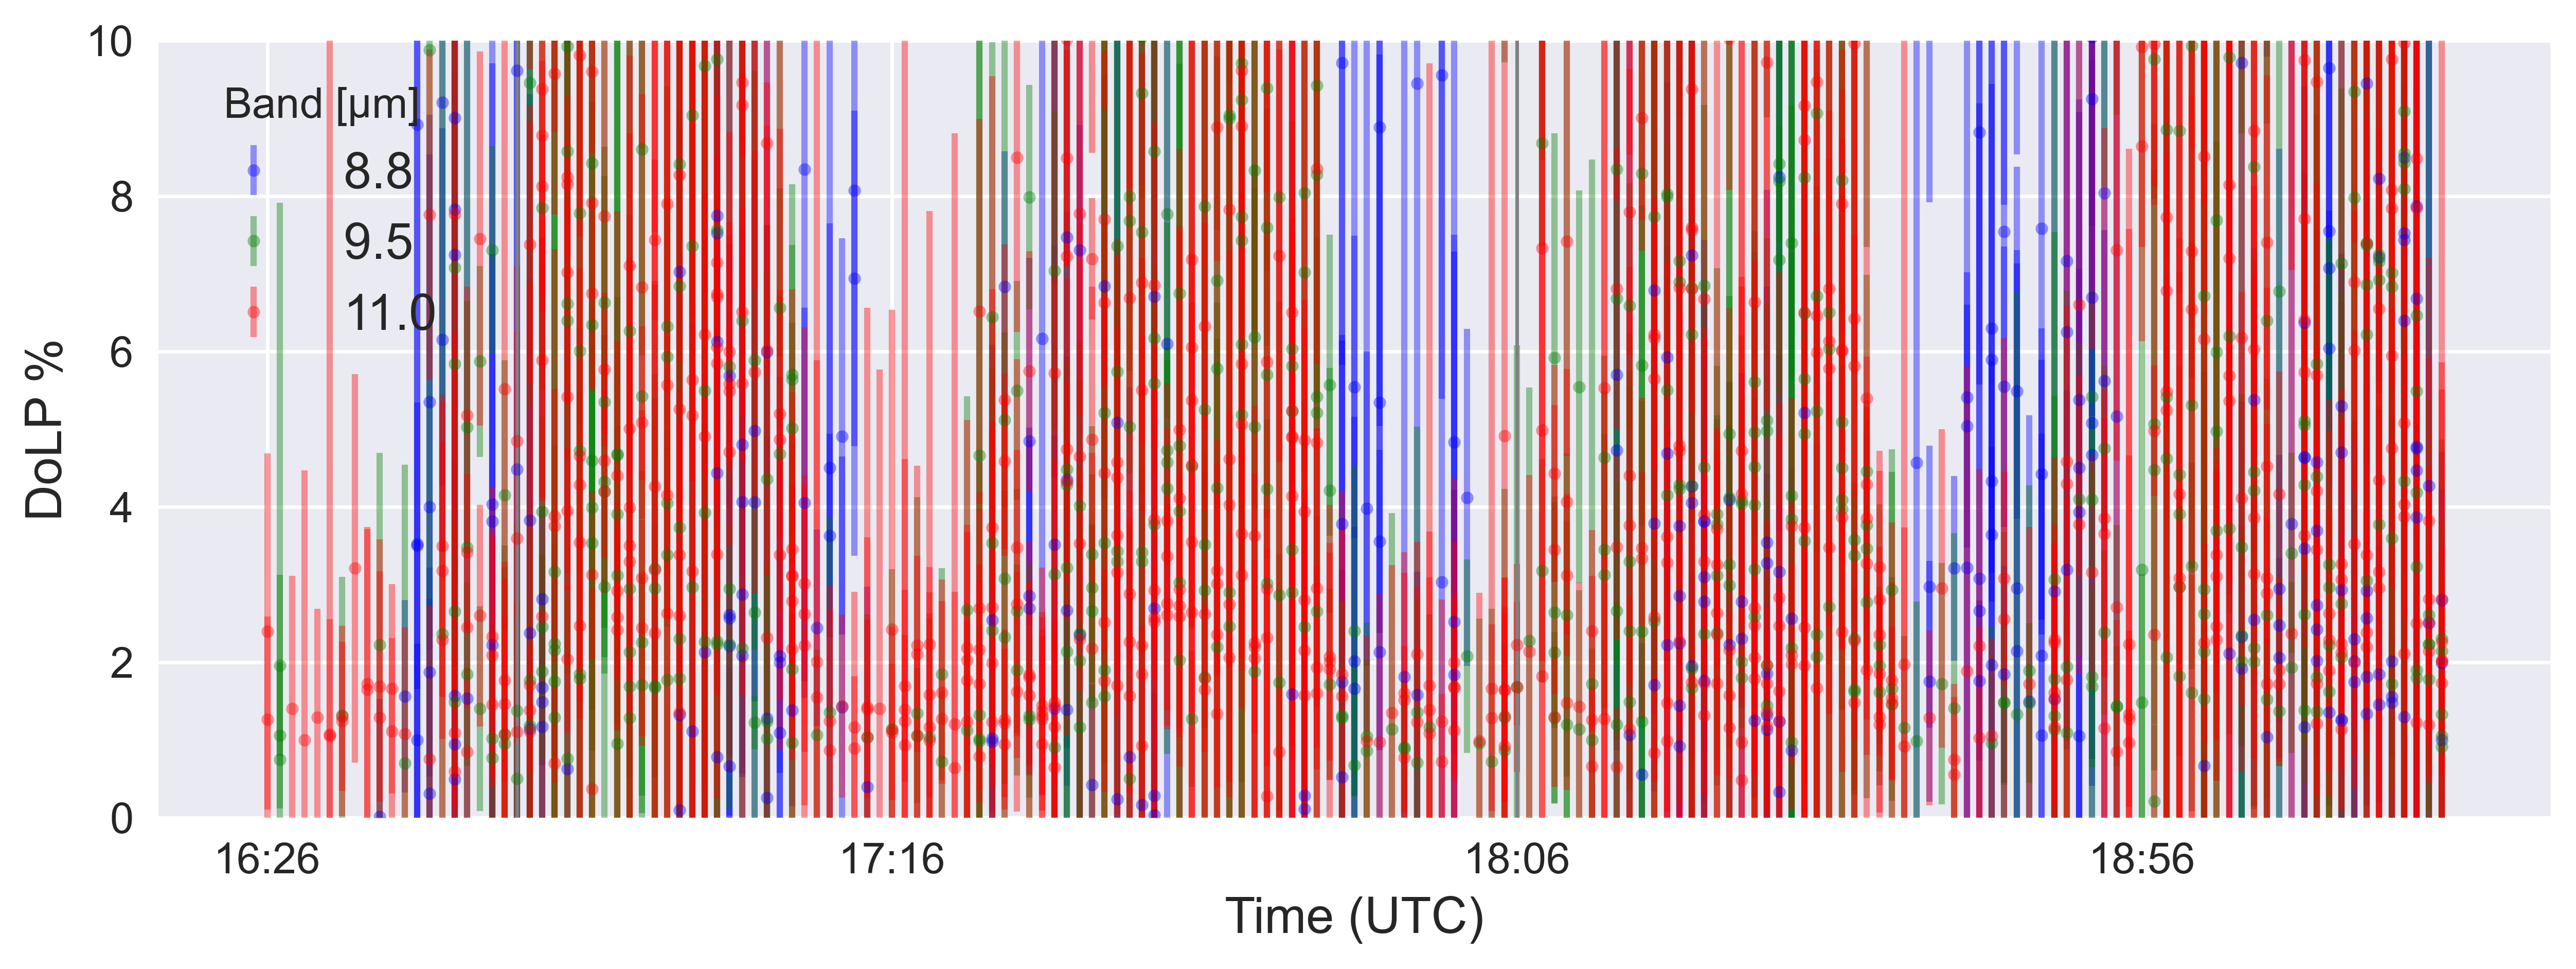

In [68]:
a = .4
fig2, ax = plt.subplots(1,1,figsize = (12,4),dpi = 500)
plt.errorbar(times[1191:],np.nanmean(np.reshape(dolp8,[900,7]),axis = 1),yerr = np.nanmean(np.reshape(yerr8,[900,7]),axis = 1) ,fmt = '.b',label = "8.8",alpha = a)
plt.errorbar(times[1191:],np.nanmean(np.reshape(dolp9,[900,4]),axis = 1),yerr = np.nanmean(np.reshape(yerr9,[900,4]),axis = 1),fmt = '.g',label = "9.5",alpha = a)
plt.errorbar(times[1191:],np.nanmean(np.reshape(dolp11,[900,4]),axis = 1),yerr = np.nanmean(np.reshape(yerr11,[900,4]),axis = 1),fmt = '.r',label = "11.0",alpha = a)

plt.legend(fontsize = 14,title = 'Band [$\mathdefault{\mu}$m]')
plt.ylabel("DoLP %")
plt.xlabel('Time (UTC)')
ax.xaxis.set_major_locator(ticker.MultipleLocator(50))

ax.axvline(20,color='gray', linewidth=1)#,label = "Launch")
ax.axvline(100,color='gray', linewidth=1)#,label = "Launch")



plt.ylim(0,10)
plt.show()

ValueError: 'c' argument has 18200 elements, which is inconsistent with 'x' and 'y' with size 6300.

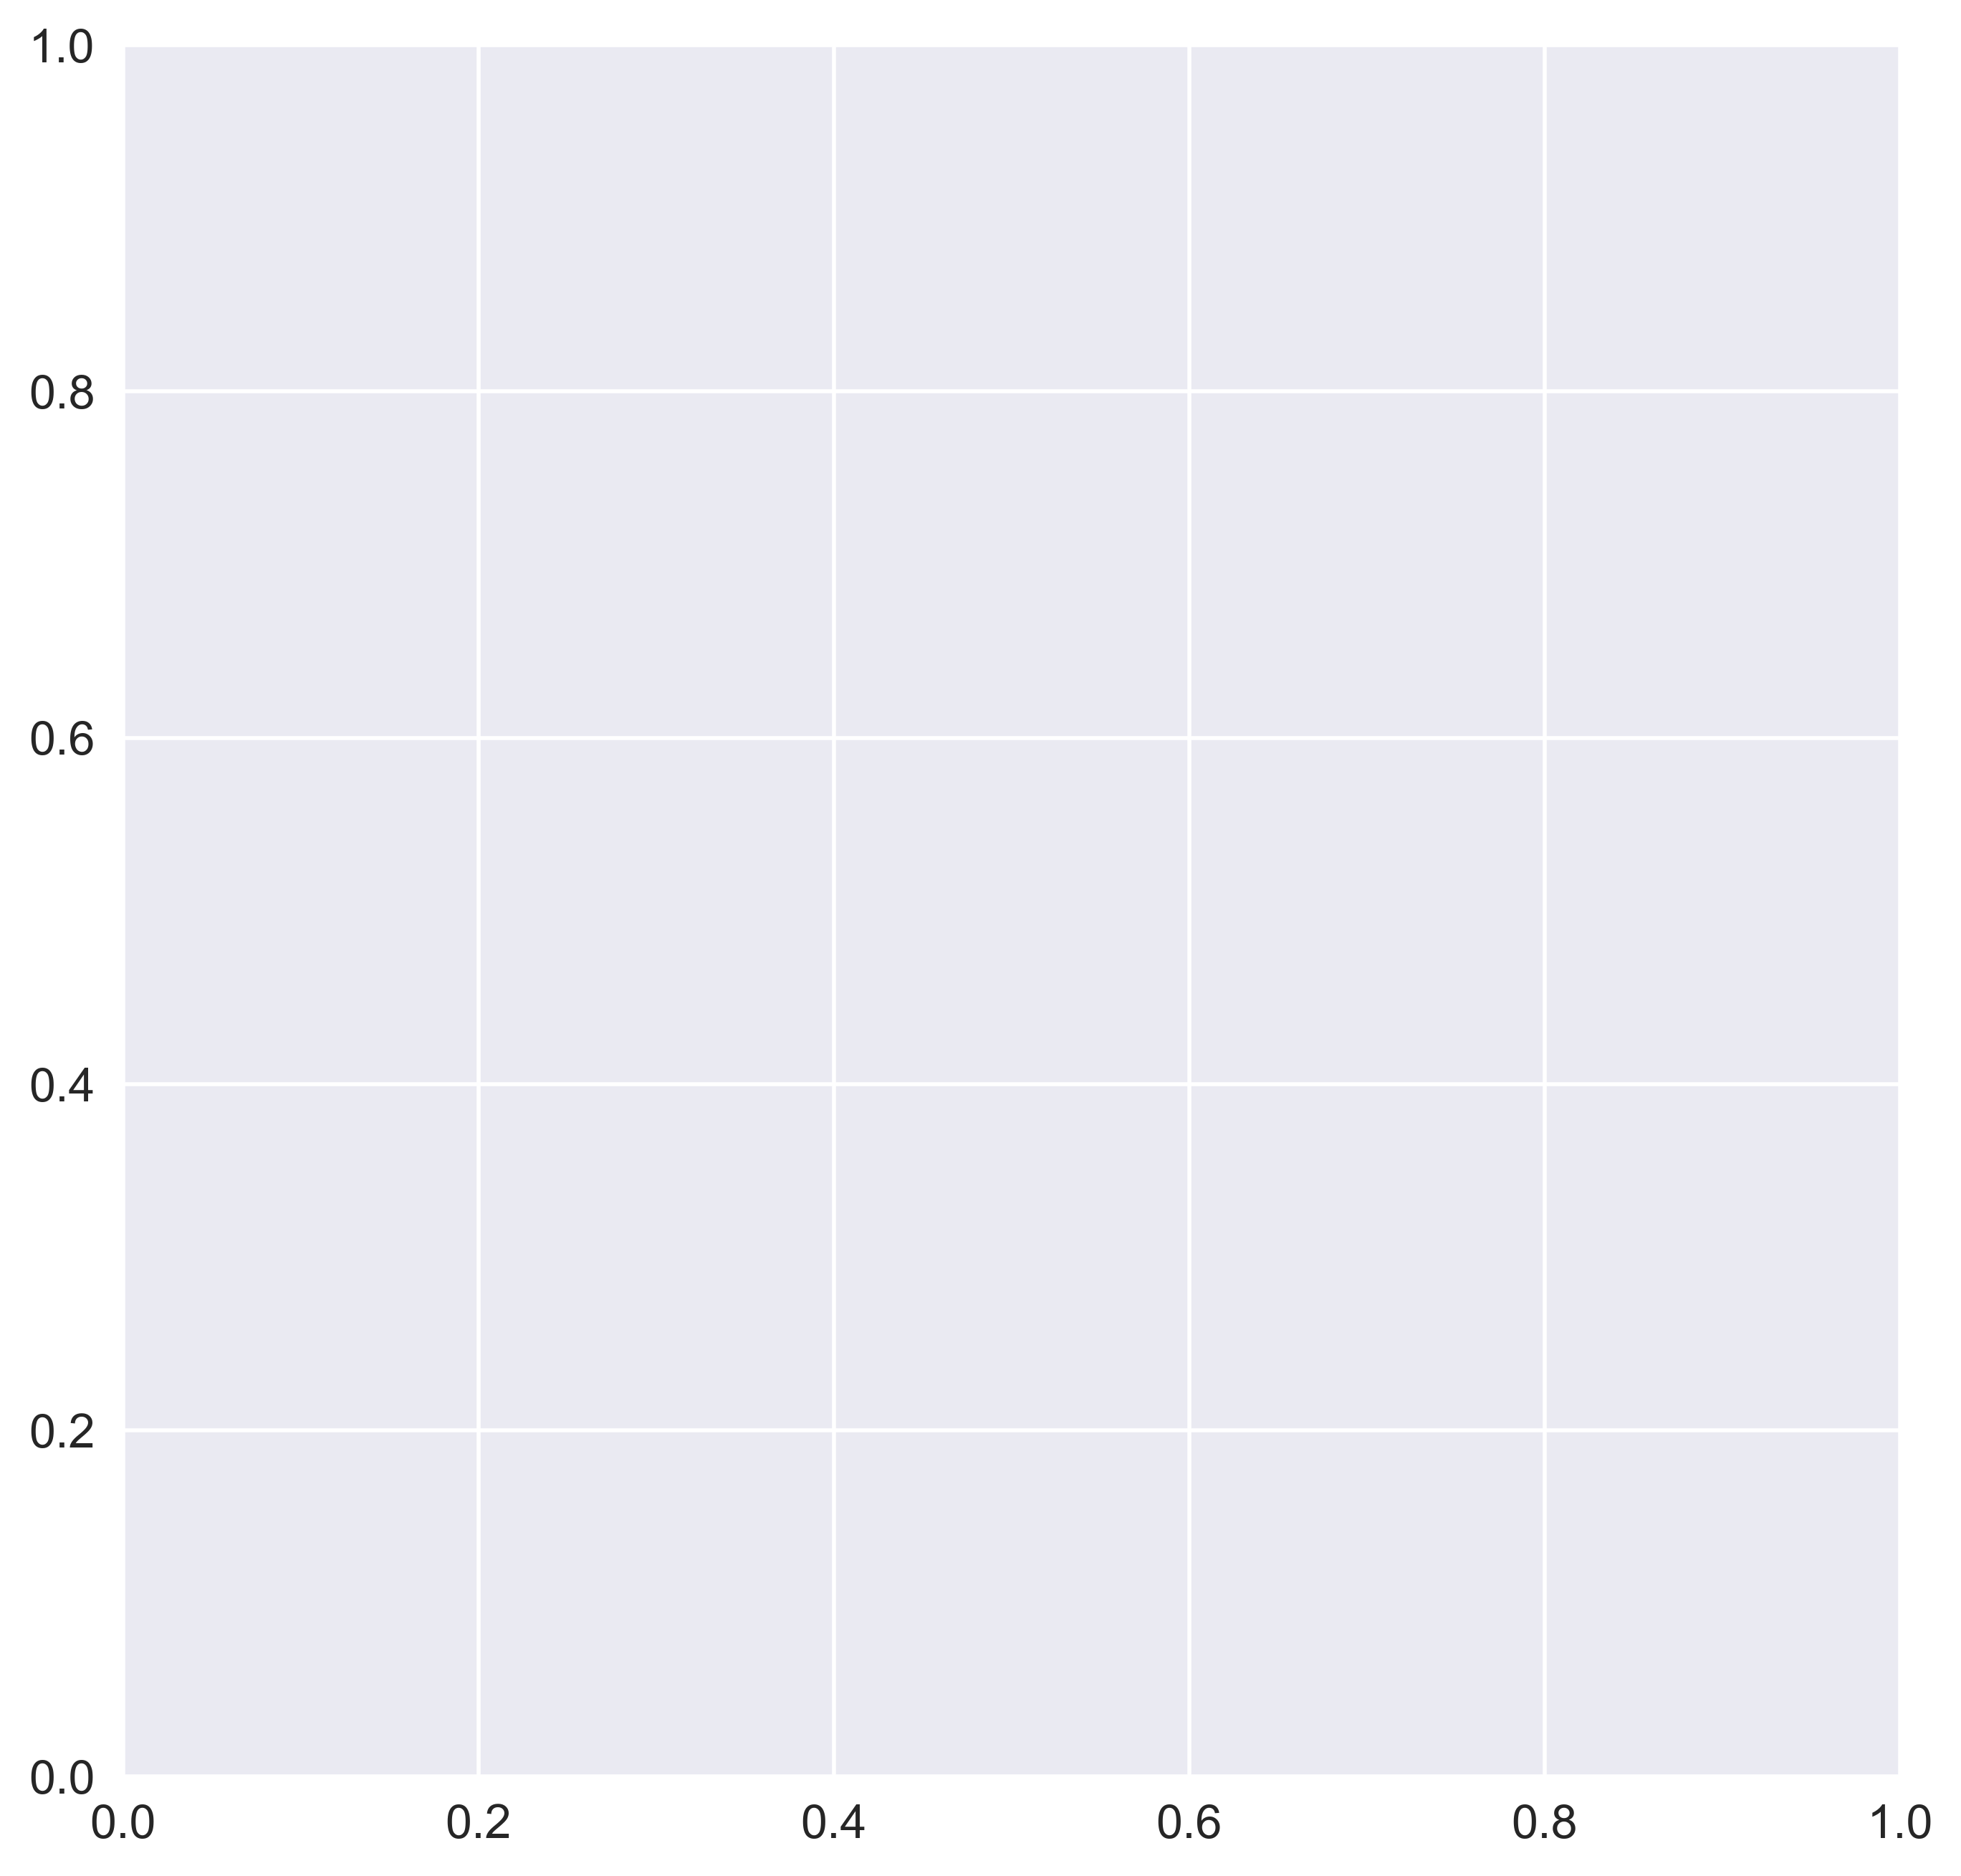

In [69]:
ran = .2
fig,ax = plt.subplots(1,1,figsize = (8,8),dpi = 300,sharex = True, sharey = True)
plt.gcf().set_dpi(400)
c = ax.scatter(dolp8,100*yerr8/dolp8,c= bts8,label = "8.8",alpha = 1,vmax = 280,vmin = 255)
ax.scatter(dolp9,100*yerr9/dolp9,c= bts9,label = "9.5",alpha = 1,vmax = 280,vmin = 255)
ax.scatter(dolp11,100*yerr11/dolp11,c= bts11,label = "11.0",alpha = 1,vmax = 280,vmin = 255)
plt.colorbar(c)

plt.legend(fontsize = 14,title = 'Band [$\mathdefault{\mu}$m]')
plt.xlabel("DoLP [%]")
plt.ylabel("RMSE Error [%]")
#plt.xlim(0,3)


ValueError: 'x' and 'y' must have the same size

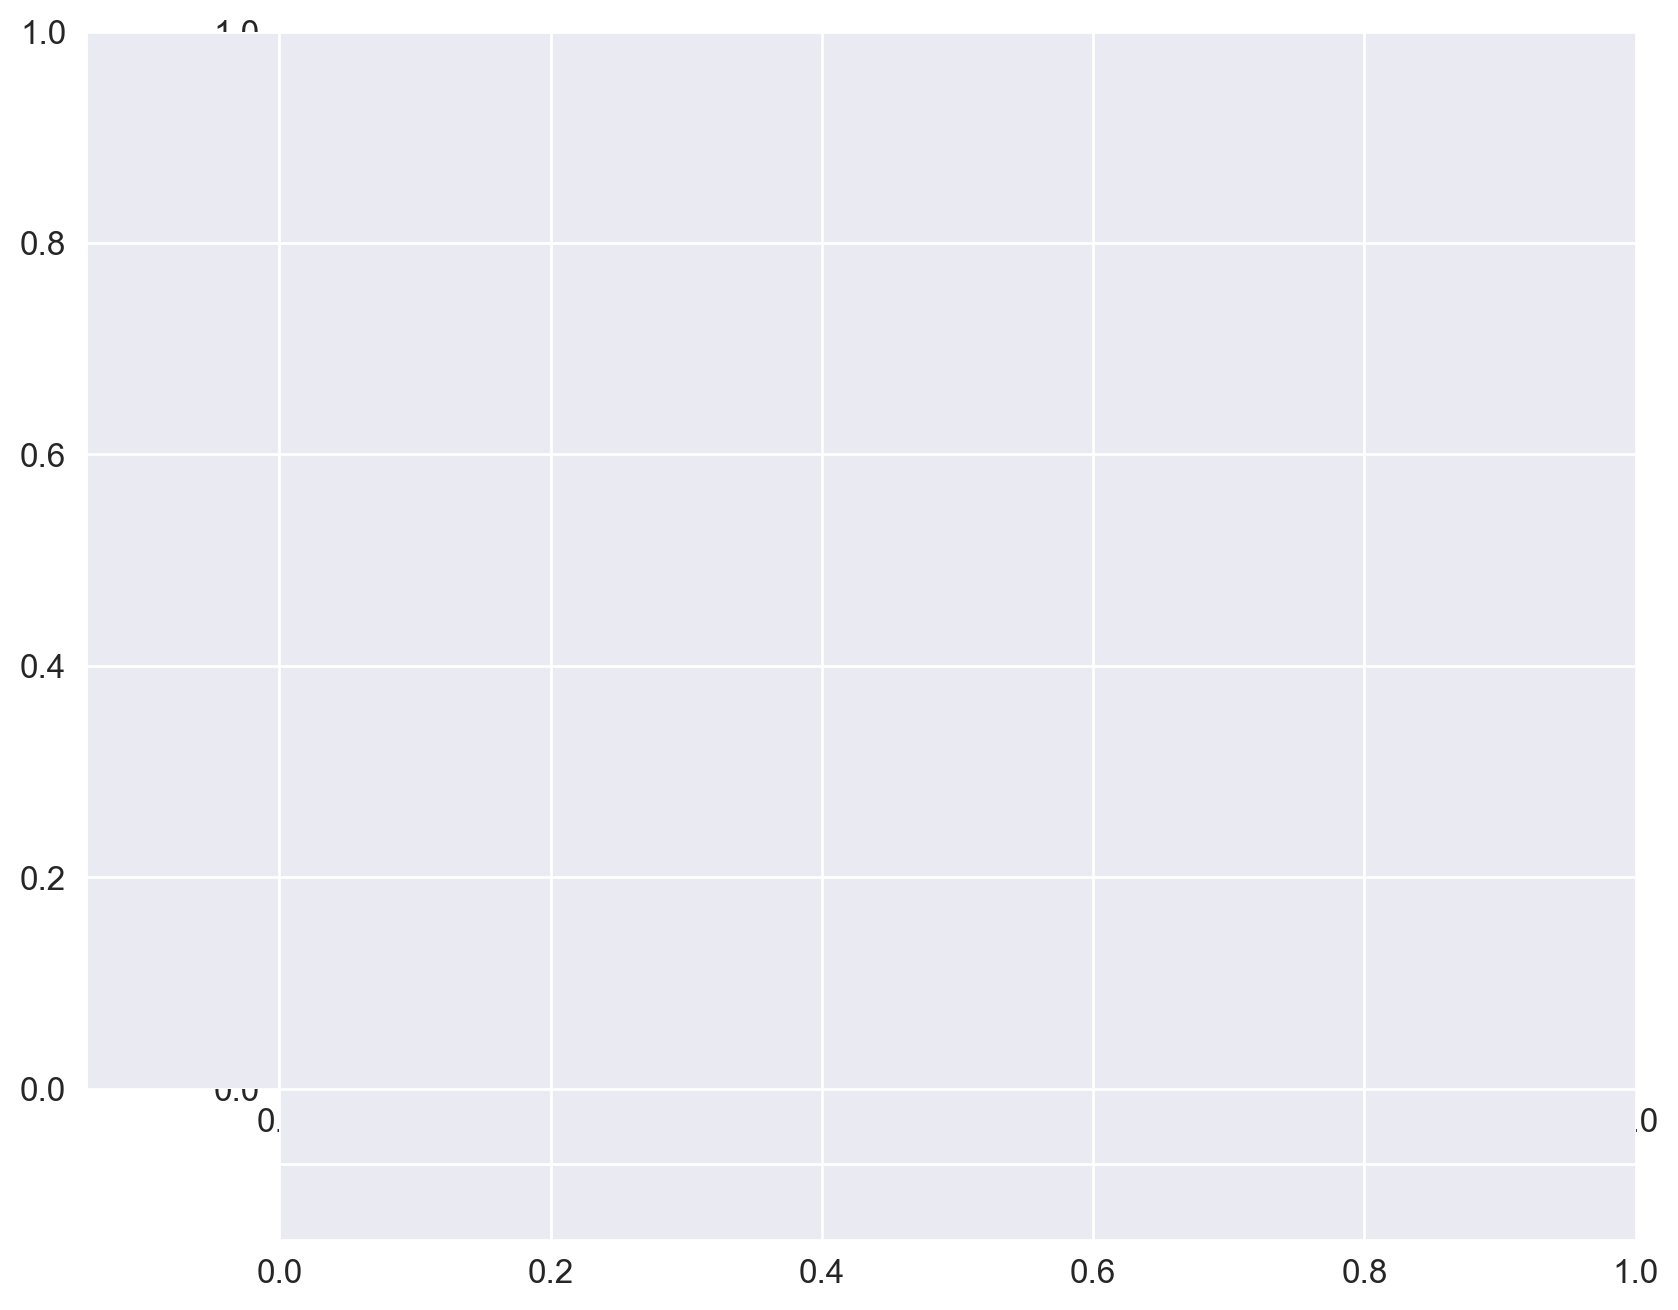

In [70]:

fig = plt.figure(figsize=(10,8),dpi = 200)
grid = plt.GridSpec(8,8, hspace=0.0, wspace=0.0)
main_ax = fig.add_subplot(grid[:-1, 1:])
y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[])
x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[])

bt_bin = 100;
dolp_bin = 100;
a = .3

main_ax.errorbar(bts8,dolp8,xerr = xerr8/2,yerr =yerr8 ,fmt = '.',c = 'b', label = "8.8$\mu m$",alpha =a)
x_hist.hist(bts8[np.argwhere(~np.isnan(dolp8))], bt_bin, histtype='stepfilled',orientation='vertical', color='blue',alpha =a)
y_hist.hist(dolp8, dolp_bin , histtype='stepfilled', orientation='horizontal', color='blue',alpha =a)

main_ax.errorbar(bts9,dolp9,xerr = xerr9/2,yerr =yerr9 ,fmt = '.',c = 'g', label = "9.5$\mu m$",alpha =a)
x_hist.hist(bts9[np.argwhere(~np.isnan(dolp9))], bt_bin, histtype='stepfilled',orientation='vertical', color='green',alpha =a)
y_hist.hist(dolp9, dolp_bin , histtype='stepfilled', orientation='horizontal', color='green',alpha =a)

main_ax.errorbar(bts11,dolp11,xerr = xerr11/2,yerr =yerr11 ,fmt = '.',c = 'r', label = "11 $\mu m$",alpha =a)
x_hist.hist(bts11[np.argwhere(~np.isnan(dolp11))], bt_bin, histtype='stepfilled',orientation='vertical', color='red',alpha =a)
y_hist.hist(dolp11, dolp_bin , histtype='stepfilled', orientation='horizontal', color='red',alpha =a)

main_ax.set_ylim(0,15)
y_hist.set_ylim(0,15)
main_ax.set_xlim(240,290)
x_hist.set_xlim(240,290)
main_ax.grid()
main_ax.set_xticks([])
main_ax.set_yticks([])


y_hist.set_ylabel("DoLP %")
x_hist.set_xlabel("Brightness Temperature [K]")
main_ax.legend()
#plt.title('11 $\mathdefault{\mu}$m Band')


# histogram on the attached axes
x_hist.invert_yaxis()
y_hist.invert_xaxis()

plt.show()

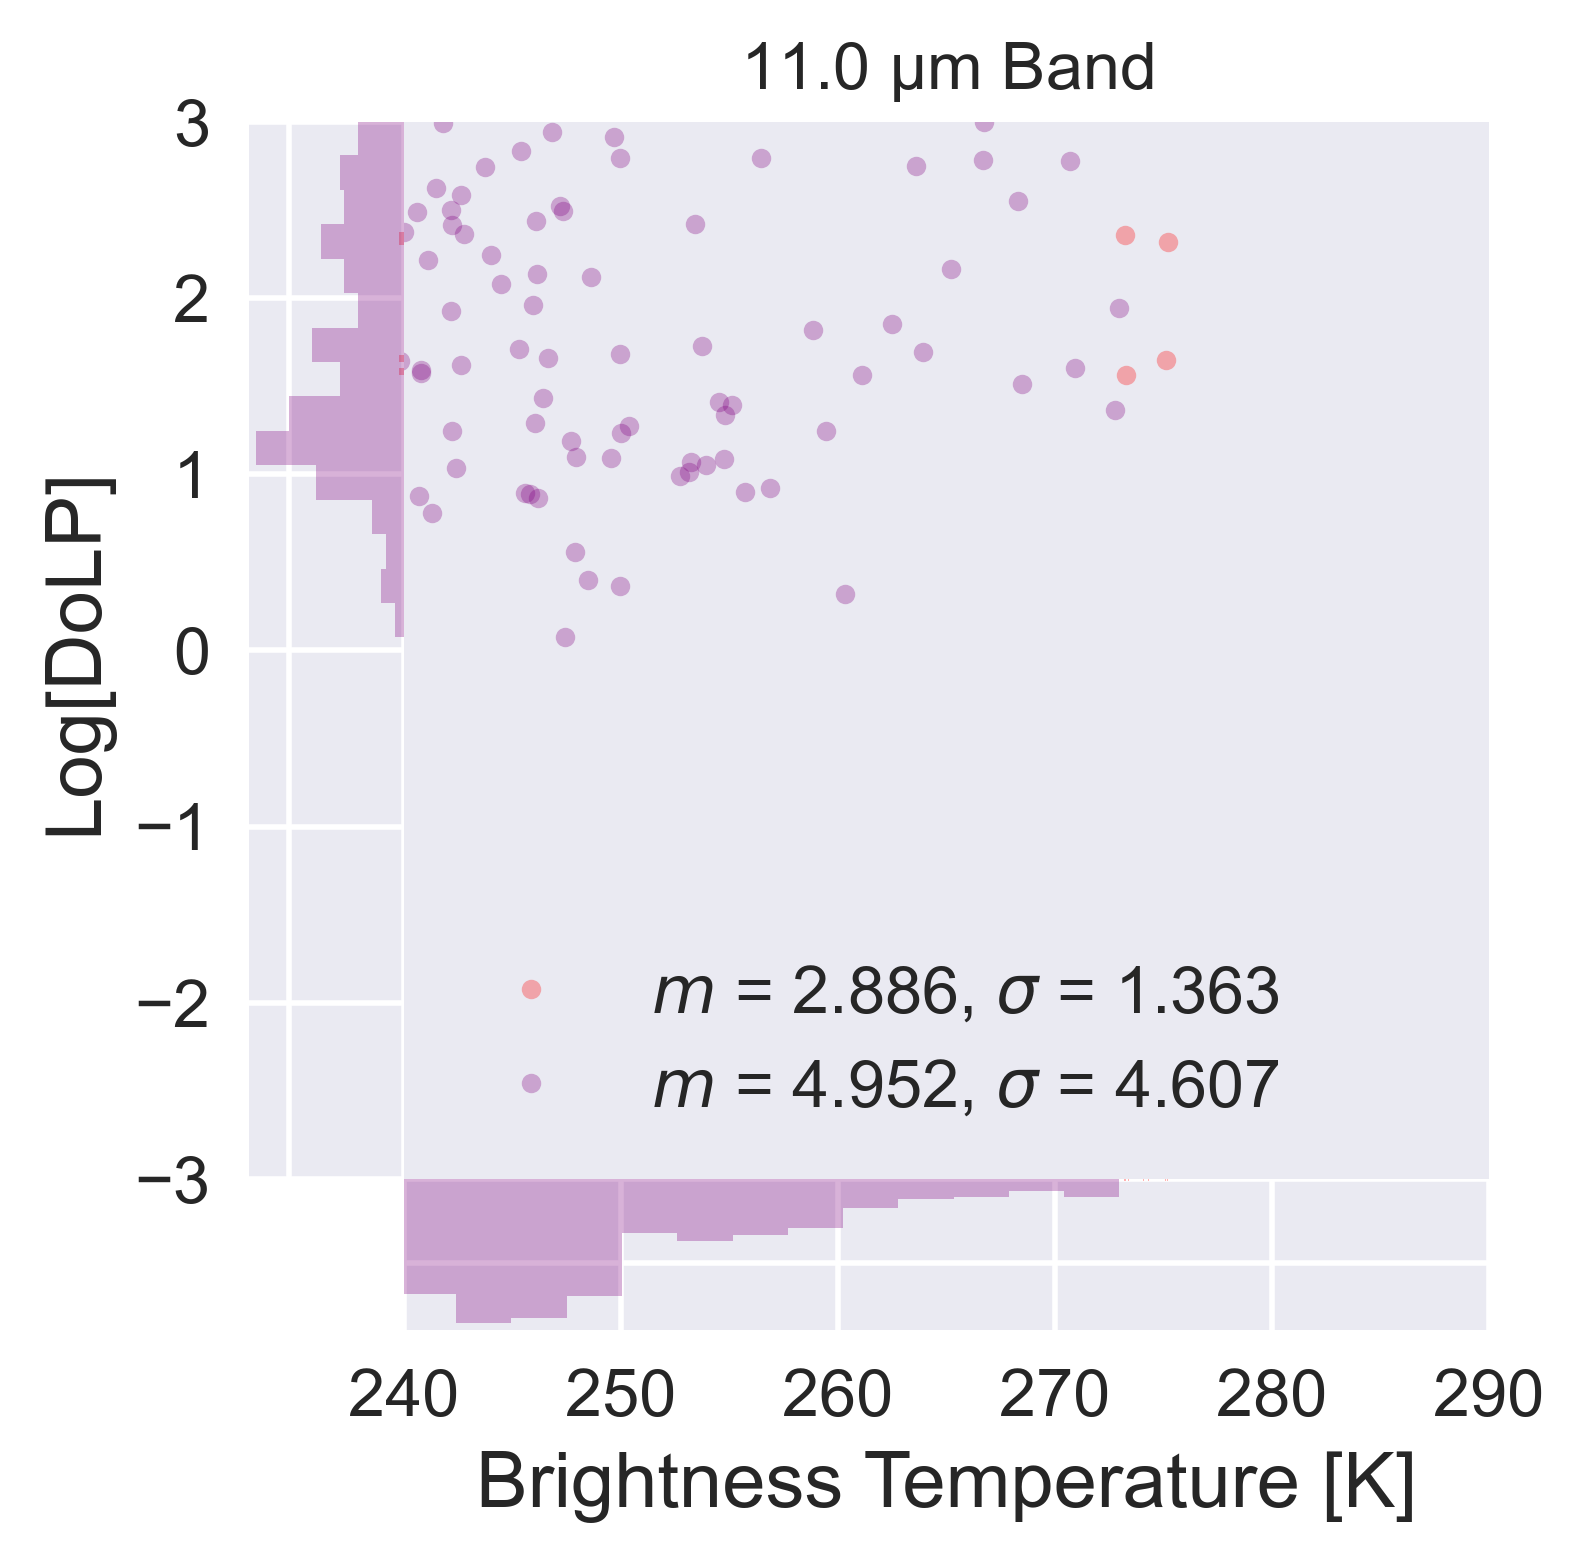

In [71]:
dolp = dolp11
bt = bts11
thresh = 273

bts = bt[np.argwhere(~np.isnan(dolp))][:,0]
bhigh = bts[np.argwhere(bts>thresh)][:,0]
dhigh = dolp[np.argwhere(bts>thresh)][:,0]

blow = bts[np.argwhere(bts<thresh)][:,0]
dlow = dolp[np.argwhere(bts<thresh)][:,0]

meanh = np.nanmean(dhigh)
meanl = np.nanmean(dlow)

sh = np.nanstd(dhigh)
sl = np.nanstd(dlow)

strhigh = '$m$ = '+str(round(meanh,3)) +', $\sigma$ = '+ str(round(sh,3))
strlow = '$m$ = '+str(round(meanl,3)) +', $\sigma$ = '+ str(round(sl,3))

fig = plt.figure(figsize=(4,4),dpi = 400)
grid = plt.GridSpec(8,8, hspace=0.0, wspace=0.0)
main_ax = fig.add_subplot(grid[:-1, 1:])
y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[])
x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[])

bt_bin = 100;
dolp_bin = 100;
a = .3

main_ax.errorbar(bhigh,dhigh,fmt = '.',c = 'r', alpha =a, label = strhigh)
x_hist.hist(bhigh, bt_bin, histtype='stepfilled',orientation='vertical', color='red',alpha =a)
y_hist.hist(dhigh, dolp_bin , histtype='stepfilled', orientation='horizontal', color='red',alpha =a)

main_ax.errorbar(blow,dlow,fmt = '.',c = 'purple', label = strlow,alpha =a)
x_hist.hist(blow, bt_bin, histtype='stepfilled',orientation='vertical', color='purple',alpha =a)
y_hist.hist(dlow, dolp_bin , histtype='stepfilled', orientation='horizontal', color='purple',alpha =a)



main_ax.set_ylim(-3,3)
y_hist.set_ylim(-3,3)
main_ax.set_xlim(240,290)
x_hist.set_xlim(240,290)
main_ax.grid()
main_ax.set_xticks([])
main_ax.set_yticks([])


y_hist.set_ylabel("Log[DoLP]")
x_hist.set_xlabel("Brightness Temperature [K]")
main_ax.set_title('11.0 $\mathdefault{\mu}$m Band')
main_ax.legend()
# histogram on the attached axes
x_hist.invert_yaxis()
y_hist.invert_xaxis()

plt.show()


In [72]:
import requests

response = requests.get('http://www.gemini.edu/sciops/ObsProcess/obsConstraints/atm-models/mktrans_nq_10_20.dat')
data = response.text 

data_by_line = data.split('\n')
for i in range(0,len(data_by_line)):
   data_by_line[i] = ' '.join(data_by_line[i].split())
   data_by_line[i] = data_by_line[i].split(' ')

In [73]:
w = np.zeros(600)
t = np.zeros(600)
for i in range(0,60000,100):
    j = int(i/100)
    float_lst = list(np.float_(data_by_line[i]))
    w[j] = float_lst[0]
    t[j] = float_lst[1]

 

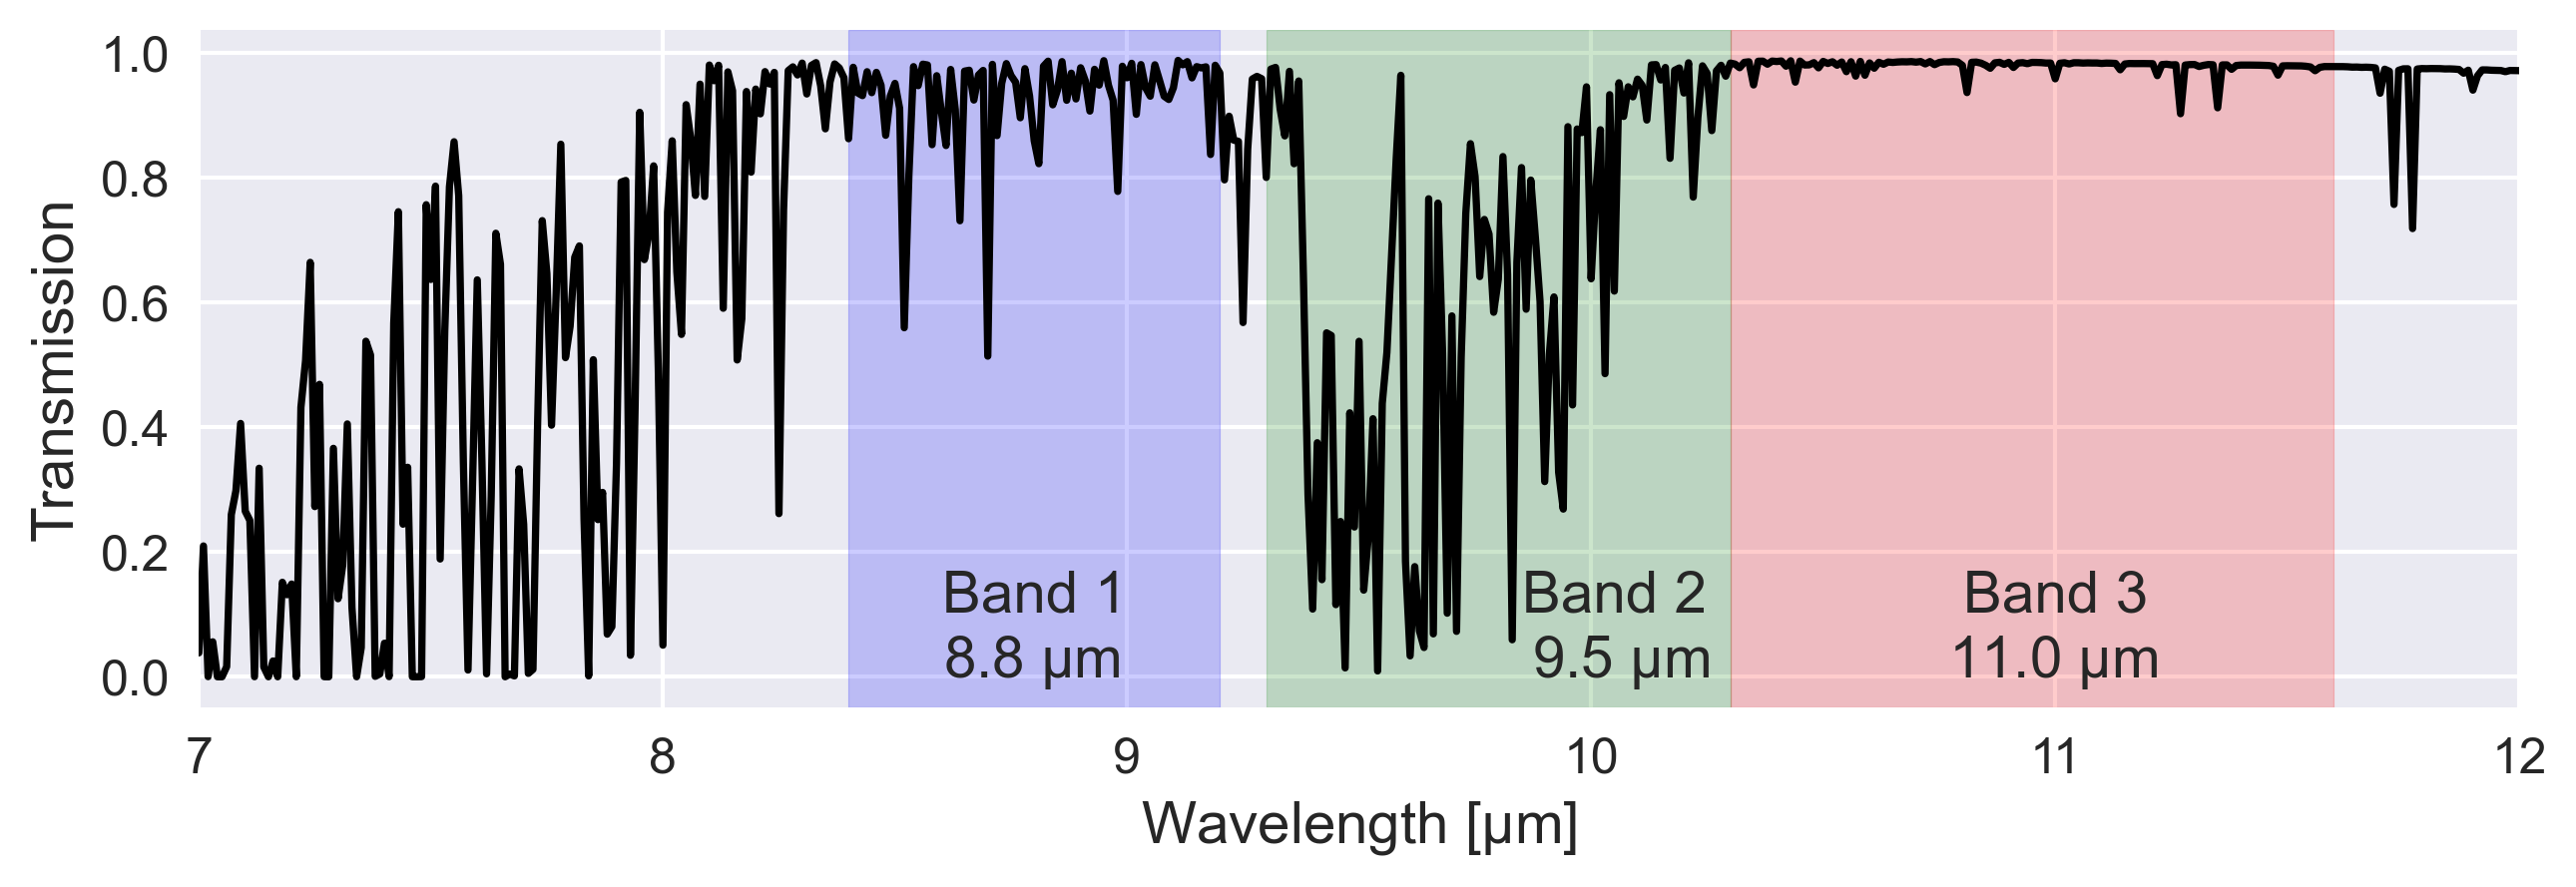

In [74]:
fig = plt.figure(figsize=(10, 3))
plt.gcf().set_dpi(300)
plt.plot(w,t,'k-')
plt.ylabel("Transmission")
plt.xlabel('Wavelength [$\mathdefault{\mu}$m]')
plt.axvspan(8.4, 9.2, color='blue', alpha=0.2)
plt.axvspan(9.3, 10.3, color='green', alpha=0.2)
plt.axvspan(10.3, 11.6, color='red', alpha=0.2)
plt.xlim(7,12)

plt.text(8.8,0,"Band 1\n8.8 $\mathdefault{\mu}$m ",fontsize = 14,ha = 'center')
plt.text(10.05,.0,"Band 2\n 9.5 $\mathdefault{\mu}$m ",fontsize = 14,ha = 'center')
plt.text(11,0,"Band 3\n11.0 $\mathdefault{\mu}$m ",fontsize = 14,ha = 'center')
plt.show()

## Stokes Plots

In [75]:
q8 = q9 = q11 =  np.zeros(0)
u8 = u9 = u11 =  np.zeros(0)
xerr8 = xerr9 = xerr11 =  np.zeros(0)
yerr8 = yerr9 = yerr11 =  np.zeros(0)
bts8  = bts9  = bts11  =  np.zeros(0)
for i in range(11,18):
    q8 = np.concatenate([q8,results[i,:,1]])
    u8 = np.concatenate([u8,results[i,:,3]])
    xerr8 = np.concatenate([xerr8,ets[i]])
    bts8  = np.concatenate([bts8,bts[i]])
    yerr8 = np.concatenate([yerr8,results[i,:,4]])
    
for i in range(24,28):
    q9 = np.concatenate([q9,results[i,:,1]])
    u9 = np.concatenate([u9,results[i,:,3]])
    xerr9 = np.concatenate([xerr9,ets[i]])
    bts9  = np.concatenate([bts9,bts[i]])
    yerr9 = np.concatenate([yerr9,results[i,:,4]])
    
for i in range(28,32):
    q11 = np.concatenate([q11,results[i,:,1]])
    u11 = np.concatenate([u11,results[i,:,3]])
    xerr11 = np.concatenate([xerr11,ets[i]])
    bts11  = np.concatenate([bts11,bts[i]])
    yerr11 = np.concatenate([yerr11,results[i,:,4]])

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 0 dimension(s)

In [43]:
q8

array([        nan,         nan,  0.00074728, ...,         nan,
               nan, -0.00082445])

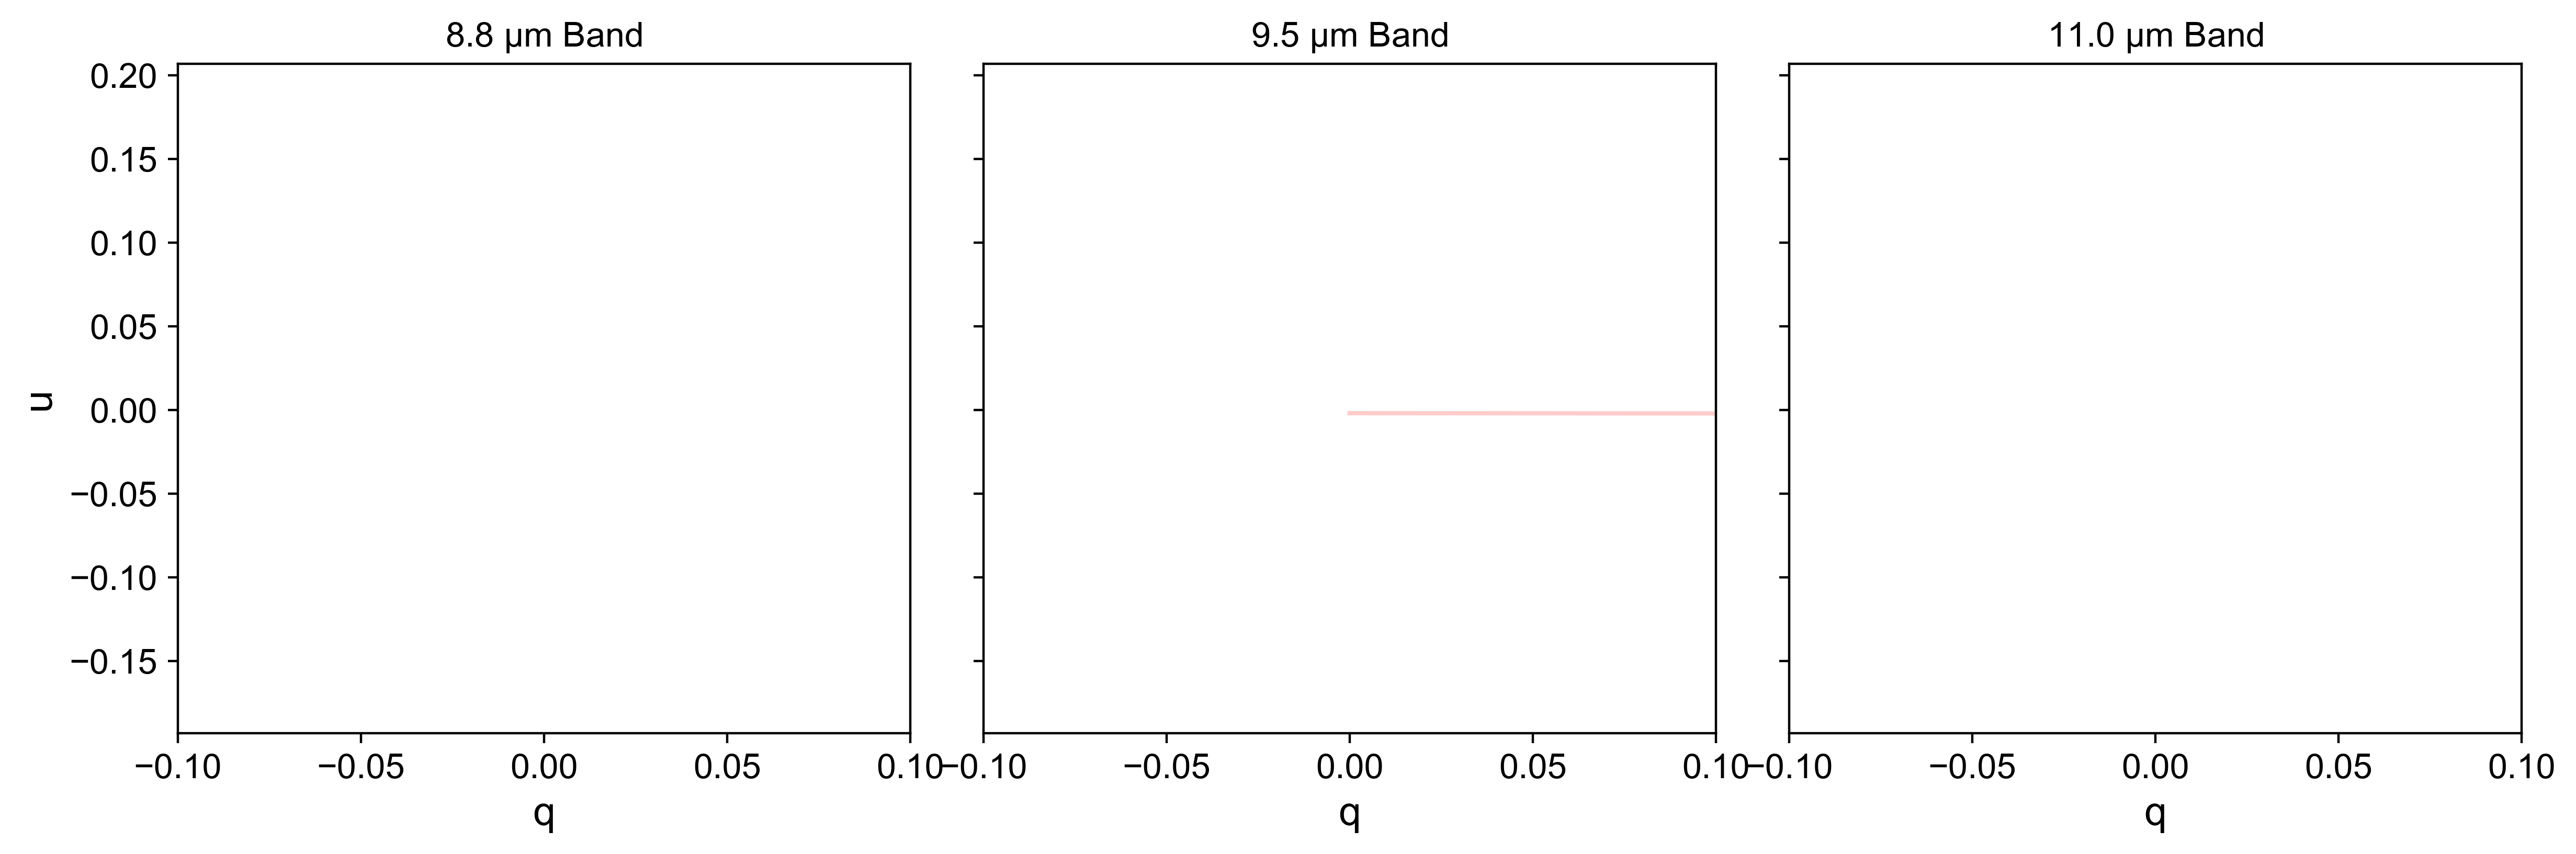

In [44]:


#make colormap indicating cloud phase
liquid = cm.get_cmap('Reds_r', 60)
mixed = cm.get_cmap('RdPu_r', 90)
ice = cm.get_cmap('PuBu_r', 120)

newcolors = np.vstack((ice(np.linspace(0, .5, 60)),
                       liquid(np.linspace(0, .5, 60))))
newcmp = ListedColormap(newcolors, name='Phases')

ran = .1
fig,ax = plt.subplots(1,3,figsize=(16, 4),sharex=True,sharey=True)
plt.gcf().set_dpi(400)
c=ax[0].plot(q8,c = 'r',alpha = .2 )
ax[1].plot(q9 ,c = 'r',alpha = .2 )
ax[2].plot(q11,c = 'r',alpha = .2 )
plt.xlim(-ran,ran)
#plt.ylim(-ran,ran)
plt.gridlines = True

fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.1, hspace=0.02)

ax[2].set_title('11.0 $\mathdefault{\mu}$m Band')
ax[1].set_title('9.5 $\mathdefault{\mu}$m Band')
ax[0].set_title('8.8 $\mathdefault{\mu}$m Band')

for i in range(3):
    ax[i].set_xlabel("q")
ax[0].set_ylabel("u")

plt.show()

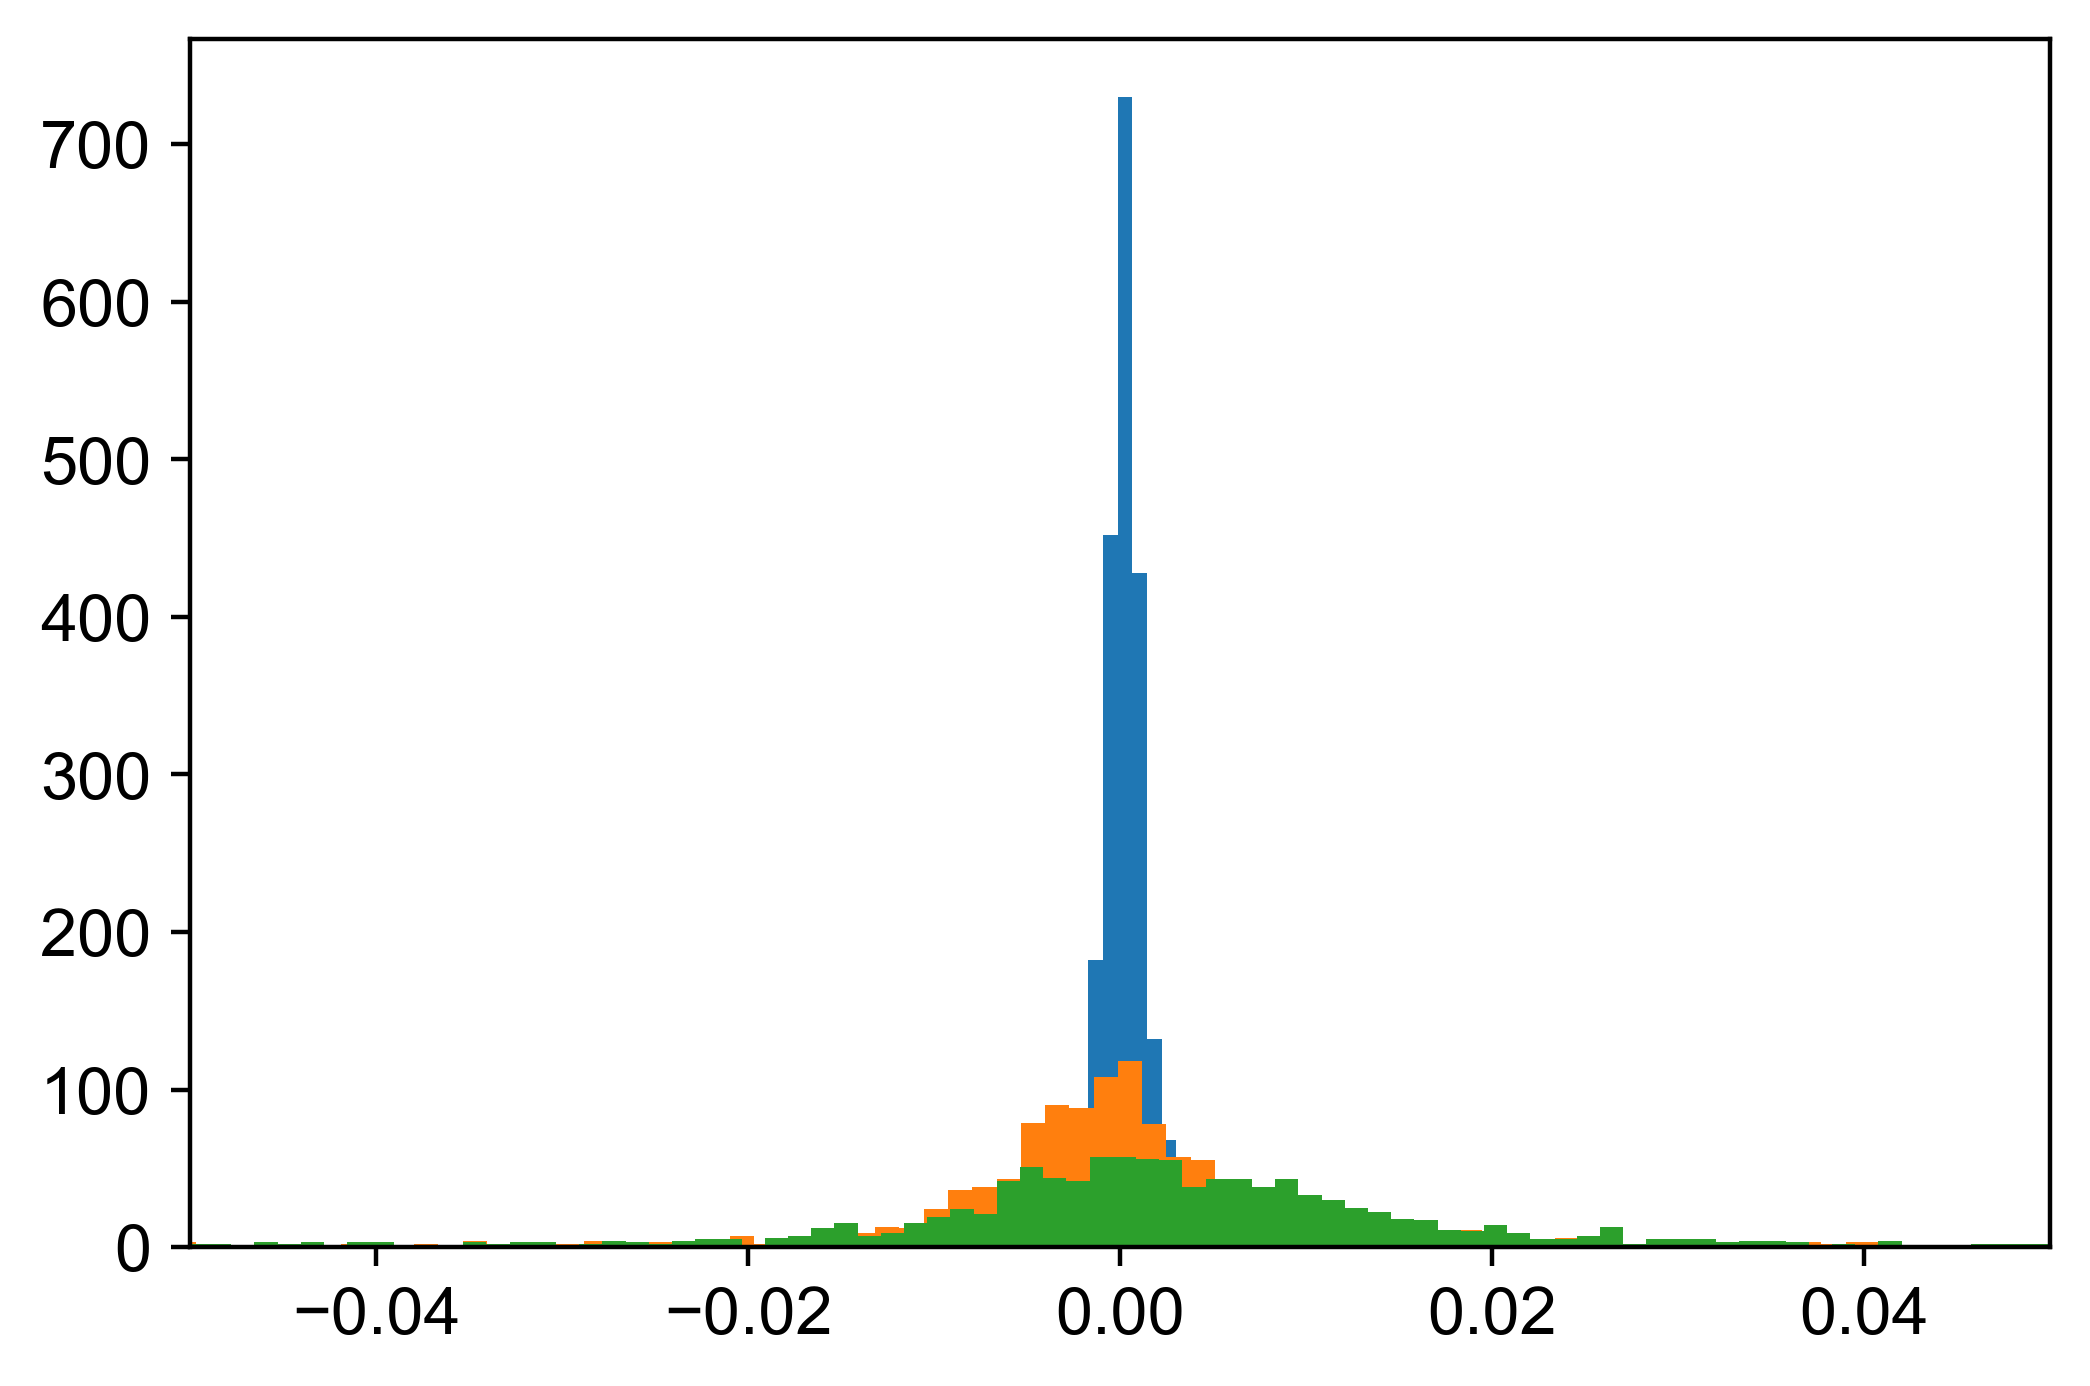

In [52]:
#make colormap indicating cloud phase
liquid = cm.get_cmap('Reds_r', 60)
mixed = cm.get_cmap('RdPu_r', 90)
ice = cm.get_cmap('PuBu_r', 120)

newcolors = np.vstack((ice(np.linspace(0, .5, 60)),
                       liquid(np.linspace(0, .5, 60))))
newcmp = ListedColormap(newcolors, name='Phases')

ran = .2
fig = plt.plot(figsize=(16, 4),sharex=True,sharey=True)
plt.gcf().set_dpi(400)
plt.hist(q8 ,400)
plt.hist(q9+u9 ,400)
plt.hist(q11+u11 ,400)

plt.xlim(-.05,.05)
#plt.ylim(-ran,ran)

ax[2].set_title('11.0 $\mathdefault{\mu}$m Band')
ax[1].set_title('9.5 $\mathdefault{\mu}$m Band')
ax[0].set_title('8.8 $\mathdefault{\mu}$m Band')

for i in range(3):
    ax[i].set_xlabel("q")
ax[0].set_ylabel("u")

plt.show()

ValueError: cannot reshape array of size 900 into shape (900,7)

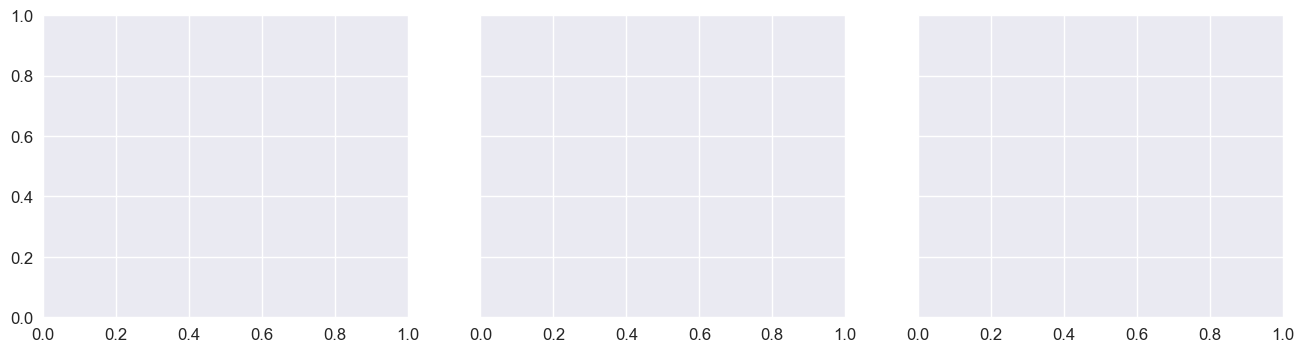

In [76]:
ran = .1
fig,ax = plt.subplots(1,3,figsize=(16, 4),sharex=True,sharey = True)
plt.gcf().set_dpi(100)
ax[0].hist(np.nanmean(np.reshape(q8,[900,7]),axis = 1) ,100)
ax[1].hist(np.nanmean(np.reshape(q9,[900,4]),axis = 1),100)
ax[2].hist(np.nanmean(np.reshape(q11,[900,4]),axis = 1),100)

#plt.xlim(-ran,ran)
#plt.ylim(-ran,ran)
plt.gridlines = True

ax[2].set_title('11.0 $\mathdefault{\mu}$m Band')
ax[1].set_title('9.5 $\mathdefault{\mu}$m Band')
ax[0].set_title('8.8 $\mathdefault{\mu}$m Band')

for i in range(3):
    ax[i].set_xlabel("q")
    #ax[i].set_xlim([-.1,.1])
ax[0].set_ylabel("u")

plt.show()

In [213]:
def circular_hist(ax, x, bins=16, density=True, offset=0, gaps=True,color = 'k'):
    """
    Produce a circular histogram of angles on ax.

    Parameters
    ----------
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        axis instance created with subplot_kw=dict(projection='polar').

    x : array
        Angles to plot, expected in units of radians.

    bins : int, optional
        Defines the number of equal-width bins in the range. The default is 16.

    density : bool, optional
        If True plot frequency proportional to area. If False plot frequency
        proportional to radius. The default is True.

    offset : float, optional
        Sets the offset for the location of the 0 direction in units of
        radians. The default is 0.

    gaps : bool, optional
        Whether to allow gaps between bins. When gaps = False the bins are
        forced to partition the entire [-pi, pi] range. The default is True.

    Returns
    -------
    n : array or list of arrays
        The number of values in each bin.

    bins : array
        The edges of the bins.

    patches : `.BarContainer` or list of a single `.Polygon`
        Container of individual artists used to create the histogram
        or list of such containers if there are multiple input datasets.
    """
    # Wrap angles to [-pi, pi)
    x = (x+np.pi) % (2*np.pi) - np.pi

    # Force bins to partition entire circle
    if not gaps:
        bins = np.linspace(-np.pi, np.pi, num=bins+1)

    # Bin data and record counts
    n, bins = np.histogram(x, bins=bins)

    # Compute width of each bin
    widths = np.diff(bins)

    # By default plot frequency proportional to area
    if density:
        # Area to assign each bin
        area = n / x.size
        # Calculate corresponding bin radius
        radius = (area/np.pi) ** .5
    # Otherwise plot frequency proportional to radius
    else:
        radius = n

    # Plot data on ax
    patches = ax.bar(bins[:-1], radius, zorder=1, align='edge', width=widths,
                     edgecolor=color, fill=False, linewidth=1)

    # Set the direction of the zero angle
    ax.set_theta_offset(offset)

    # Remove ylabels for area plots (they are mostly obstructive)
    ticks = [0,np.pi/2,np.pi,3*np.pi/2]
    ax.set_xticks(ticks)

    dic = {0:'H',np.pi/2:'45$^\circ$',np.pi:'V',3*np.pi/2:'135$^\circ$'}
    labels = [ticks[i] if t not in dic.keys() else dic[t] for i,t in enumerate(ticks)]
    ## or 
    # labels = [dic.get(t, ticks[i]) for i,t in enumerate(ticks)]

    ax.set_xticklabels(labels,fontsize = 16)
    
    if density:
        ax.set_yticks([])

    return n, bins, patches

In [204]:
aolp8 = np.nanmean(np.reshape(q8,[900,7]),axis = 1)
aolp8 = aolp8[~np.isnan(aolp8)]

aolp9 = np.nanmean(np.reshape(q9,[900,4]),axis = 1)
aolp9 = aolp9[~np.isnan(aolp9)]

aolp11 = np.nanmean(np.reshape(q11,[900,4]),axis = 1)
aolp11 = aolp11[~np.isnan(aolp11)]



/Users/kirahart/opt/anaconda3/envs/database/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.
/Users/kirahart/opt/anaconda3/envs/database/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/Users/kirahart/opt/anaconda3/envs/database/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


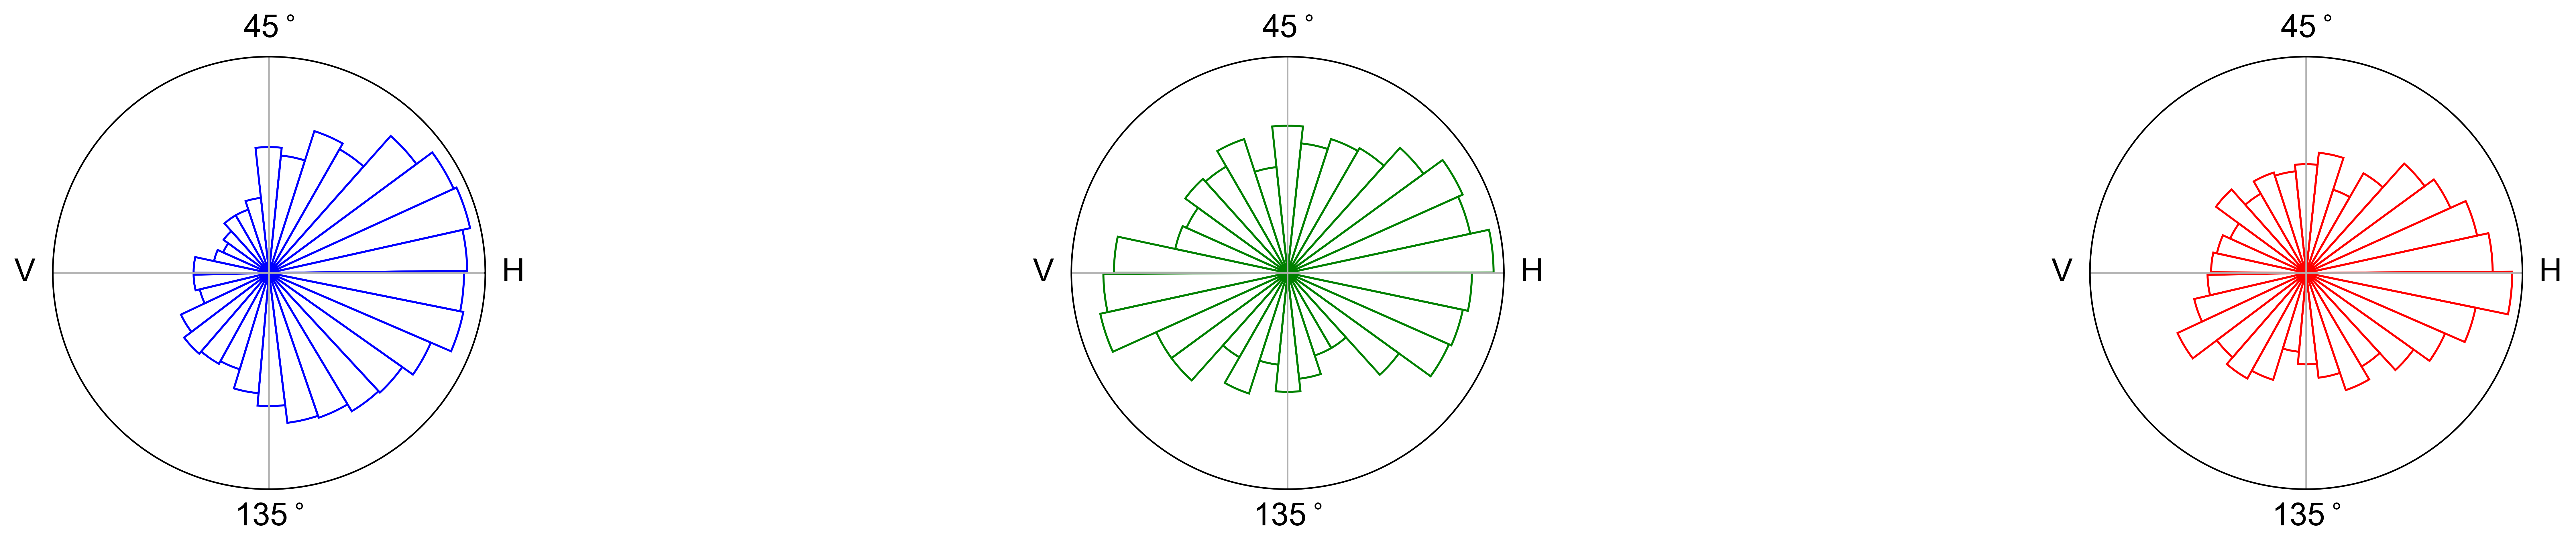

In [216]:
# Construct figure and axis to plot on
fig, ax = plt.subplots(1, 3, subplot_kw=dict(projection='polar'),figsize = (26,4))
plt.gcf().set_dpi(500)

# Visualise by area of bins
a=circular_hist(ax[0], 2*(aolp8-np.pi/8),30,density = True,color = 'b')
# Visualise by radius of bins
b=circular_hist(ax[1], 2*(aolp9+np.pi/8),30,density = True, color = 'g')

# Visualise by radius of bins
c=circular_hist(ax[2], 2*aolp11,30,density = True,color = 'r')

plt.show()



/Users/kirahart/opt/anaconda3/envs/database/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/kirahart/opt/anaconda3/envs/database/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/Users/kirahart/opt/anaconda3/envs/database/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


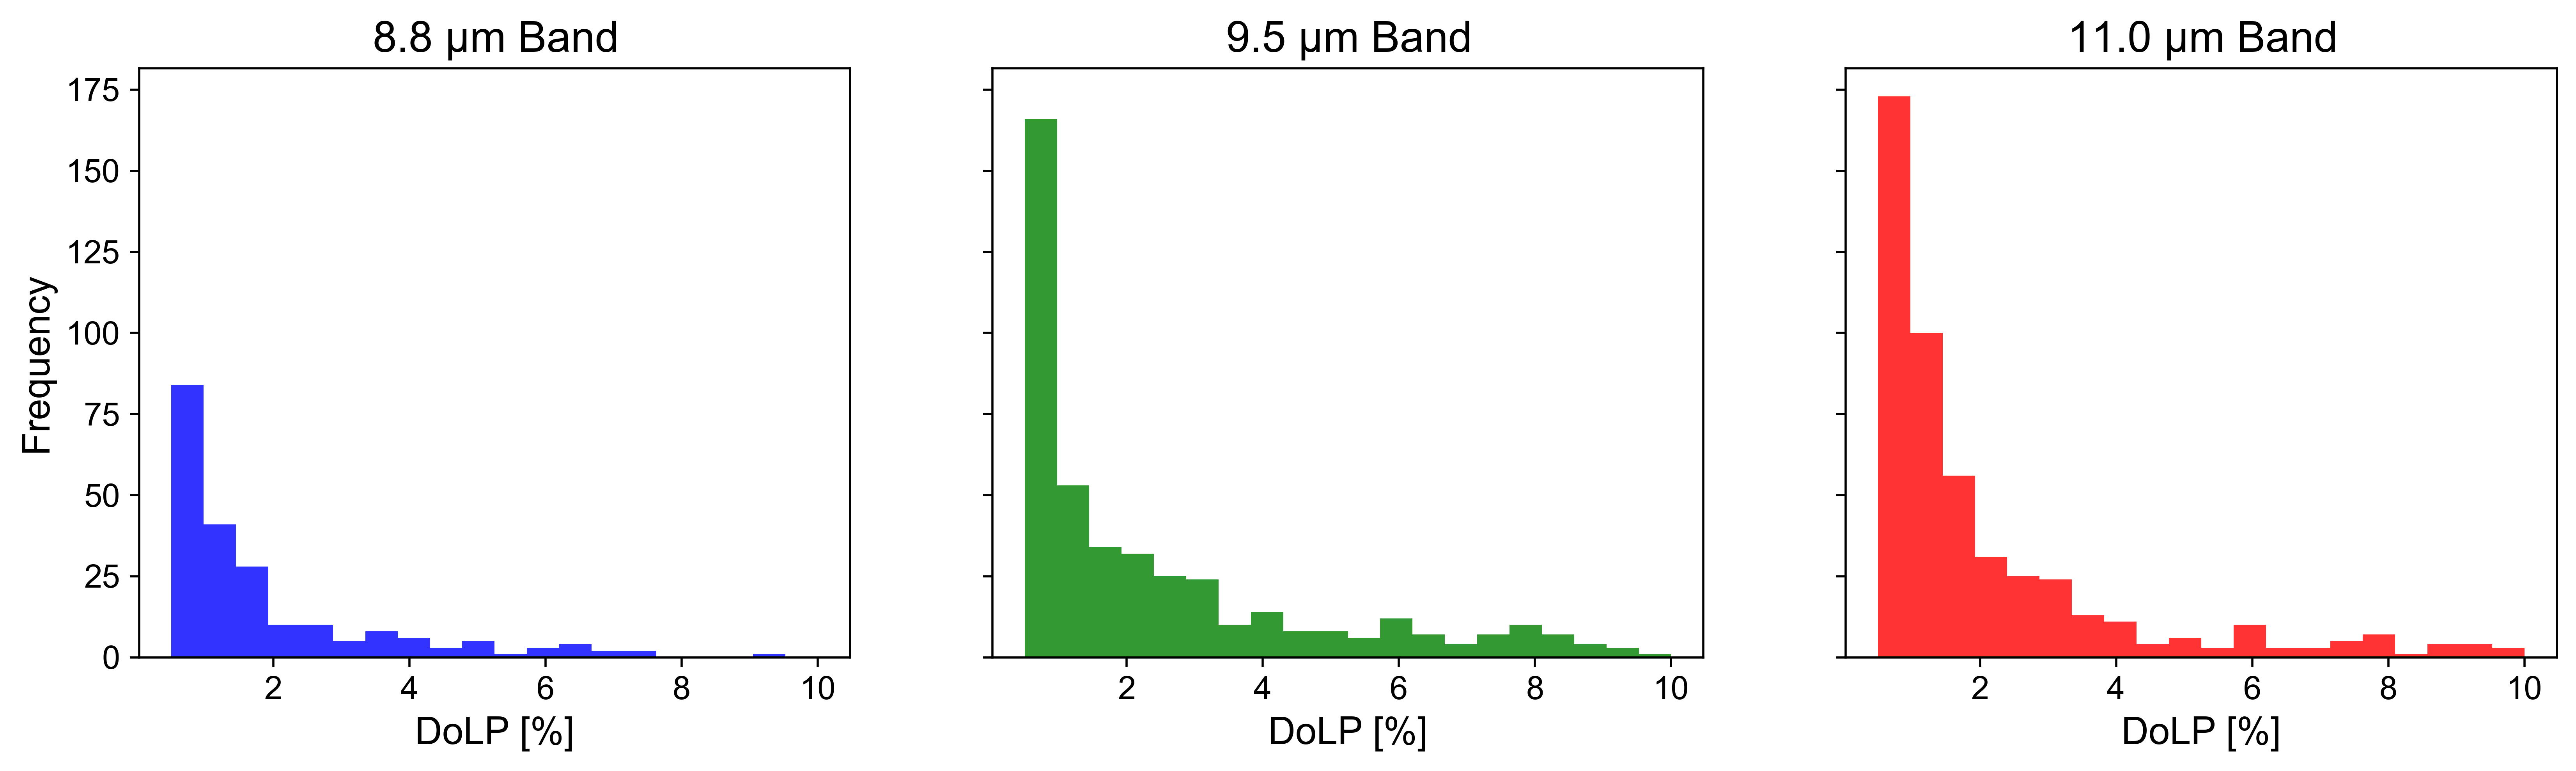

In [208]:
fig,ax = plt.subplots(1,3,figsize=(16, 4),sharex=True,sharey = True)
plt.gcf().set_dpi(500)
ax[0].hist(np.nanmean(np.reshape(dolp8,[900,7]),axis = 1) ,20,range=(.5,10),color = 'b',alpha = .8)
ax[1].hist(np.nanmean(np.reshape(dolp9,[900,4]),axis = 1),20,range=(.5,10),color = 'g',alpha = .8)
ax[2].hist(np.nanmean(np.reshape(dolp11,[900,4]),axis = 1),20,range=(.5,10),color = 'r',alpha = .8)

#plt.xlim(-ran,ran)
#plt.ylim(-ran,ran)
plt.gridlines = True

ax[2].set_title('11.0 $\mathdefault{\mu}$m Band',fontsize = 16)
ax[1].set_title('9.5 $\mathdefault{\mu}$m Band',fontsize = 16)
ax[0].set_title('8.8 $\mathdefault{\mu}$m Band',fontsize = 16)

for i in range(3):
    ax[i].set_xlabel("DoLP [%]")
    #ax[i].set_xlim([0,10])
ax[0].set_ylabel("Frequency")

plt.show()